### Density Estimation 

- Following Manski et al.(2009)
- Three cases 
   - case 1. 3+ intervales with positive probabilities, to be fitted with a generalized beta distribution
   - case 2. exactly 2 adjacent intervals with positive probabilities, to be fitted with a triangle distribution 
   - case 3. one interval only, to be fitted with a uniform distribution

In [1]:
from scipy.stats import gamma
from scipy.stats import beta 
from scipy.stats import triang # new
from scipy.stats import uniform # new
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import pandas as pd

In [2]:
# We need that for the 90-10 ratio:
def quantile(x,quantiles):
    xsorted = sorted(x)
    qvalues = [xsorted[int(q * len(xsorted))] for q in quantiles]
    return qvalues

### Case 1. Generalized Beta Distribution

In [3]:
def GeneralizedBetaEst(bin,probs):
    """
    This fits a histogram with positive probabilities in at least 3 bins to a generalized beta distribution.
    Depending on if there is open-ended bin on either side with positive probability, 
       the estimator decides to estimate 2 or 4 parameters, respectively. 
       
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
                 
    returns
    -------
    moments:  ndarray of 2 or 4  
              2:  alpha and beta 
              4:  alpha, beta, lb, ub, e.g. lb=0 and ub=1 for a standard beta distribution
    """
    # n+1 bins and n probs, both are arrays
    if sum([probs[i]>0 for i in range(len(bin)-1)])<3:
        print("Warning: at least three bins with positive probs are needed")
        para_est=[]
    if sum(probs)!=1:
        print("probs need to sum up to 1")
        para_est=[]
    else:
        cdf = np.cumsum(probs)
        pprob=[i for i in range(len(bin)-1) if probs[i]>0]
        lb=bin[min(pprob)]
        print("lower bound is "+str(lb))
        ub=bin[max(pprob)+1]
        print("upper bound is "+str(ub))
        x0_2para = (2,1)
        x0_4para = (2,1,0,1) 
        def distance2para(paras2): # if there is no open-ended bin with positive probs 
            a,b=paras2
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        def distance4para(paras4): # if either on the left or right side one open-ended bin is with postive probs
            a,b,lb,ub=paras4
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        if lb==bin[0] and ub==bin[-1]:
            para_est = minimize(distance4para,x0_4para,method='CG')['x']
        else:
            para_est = minimize(distance2para,x0_2para,method='CG')['x']
        return para_est   # could be 2 or 4 parameters 

In [4]:
def GeneralizedBetaStats(a,b,lb,ub):
    """
    This function computes the moments of a generalized beta distribution, mean and variance for now. 
    
    parameters
    ----------
    a, b, lb, ub: floats #changed to a,b instead of alpha and beta
    
    returns
    -------
    dict:  2 keys
           mean, float 
           variance, float
           standard deviation, float
           ratio 90 10, float
    """
    # lb=0 and ub=1 for a standard beta distribution
    mean = lb + (ub-lb)*a/(a+b)
    var = (ub-lb)**2*a*b/((a+b)**2*(a+b+1))
    std = np.sqrt(var)
    # ratio
    x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
    quantiles = quantile(x,[0.1, 0.9])
    irq1090 = quantiles[0]/quantiles[1]
    return {"mean": mean,"variance":var, "std": std, "irq1090": irq1090}

### Case 2. Isosceles Triangle distribution

Two adjacent intervales $[a,b]$,$[b,c]$ are assigned probs $\alpha$ and $1-\alpha$, respectively. In the case of $\alpha<1/2$, we need to solve parameter $t$ such that $[b-t,c]$ is the interval of the distribution. Denote the height of the trangle distribution $h$. Then following two restrictions need to satisfy

\begin{eqnarray}
\frac{t^2}{t+c-b} h = \alpha \\
(t+(c-b))h = 2
\end{eqnarray}

The two equations can solve $t$ and $h$

$$\frac{t^2}{(t+c-b)^2}=\alpha$$

$$t^2 = \alpha t^2 + 2\alpha t(c-b) + \alpha(c-b)^2$$

$$(1-\alpha) t^2 - 2\alpha(c-b) t - \alpha(c-b)^2=0$$

$$\implies t =\frac{2\alpha(c-b)+\sqrt{4\alpha^2(c-b)^2+4(1-\alpha)\alpha(c-b)^2}}{2(1-\alpha)} = \frac{\alpha(c-b)+(c-b)\sqrt{\alpha}}{(1-\alpha)}$$

$$\implies h = \frac{2}{t+c-b}$$

Rearrange to solve for c:
$$ \implies c = (t - b) - \frac{2}{h} $$
$$ \implies c = ub - \frac{2}{h} $$

In [5]:
def TriangleEst(bin,probs):
    """
    The function fits histograms with exactly two adjacent 
       bins with positive probabilitie to a triangular distribution.
    It genetes the bounds of the isoceles triangle distribution. 
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 3 keys
          lb: float, left bound 
          ub: float, right bound
          h:  float, height of the triangle
          c: float, mode
    
    """
    if sum([probs[i]>0 for i in range(len(bin)-1)])==2:
        print("There are two bins with positive probs")
        pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
        if sum(pprobadj)>0:
            print('The two intervals are adjacent and not open-ended')
            min_i = min(pprobadj)
            #print(min_i)
            #print(probs[min_i])
            #print(probs[min_i+1])
            #print(pprobadj[0])
            #print(pprobadj[0]+2)
            #print(probs[min_i] > probs[min_i+1])
            #print(bin[pprobadj[0]])
            #print(bin[pprobadj[0]+2])
            if probs[min_i] > probs[min_i+1]:
                alf = probs[min_i+1]
                lb = bin[pprobadj[0]]
                scl = bin[pprobadj[0]+1]-bin[pprobadj[0]]
                t = scl*(alf/(1-alf) +np.sqrt(alf)/(1-alf))
                ub = bin[pprobadj[0]+1]+t 
                h = 2/(t+bin[pprobadj[0]+1]-bin[pprobadj[0]])
                c = ub - 2/h
            if probs[min_i] < probs[min_i+1]:
                alf = probs[min_i]
                ub = bin[pprobadj[0]+2]
                scl = bin[pprobadj[0]+2]-bin[pprobadj[0]+1]
                t = scl*(alf/(1-alf) + np.sqrt(alf)/(1-alf))
                lb = bin[pprobadj[0]+1]-t  
                h = 2/(t+bin[pprobadj[0]+2]-bin[pprobadj[0]+1])
                c = ub - 2/h
            if probs[min_i] == probs[min_i+1]:
                ub=bin[pprobadj[0]]
                lb=bin[pprobadj[0]+2]
                h = 2/(ub-lb)
                c = ub - 2/h
        else:
            lb = []
            ub = []
            h = []
            c = []
            print('Warning: the two intervals are not adjacent or are open-ended')
    return {'lb':lb,'ub':ub,"height":h,"mode":c}

#### pdf of a triangle distribution

\begin{eqnarray}
f(x)= & 1/2(x-lb) \frac{x-lb}{(ub+lb)/2}h \quad \text{if } x <(lb+ub)/2 \\
& = 1/2(ub-x) \frac{ub-x}{(ub+lb)/2}h \quad \text{if } x \geq(lb+ub)/2
\end{eqnarray}

\begin{eqnarray}
& Var(x) & = \int^{ub}_{lb} (x-(lb+ub)/2)^2 f(x) dx \\
& & = 2 \int^{(ub+lb)/2}_{lb} (x-(lb+ub)/2)^2 (x-lb) \frac{x-lb}{(ub+lb)/2}h dx
\end{eqnarray}



In [6]:
def TriangleStats(lb,ub,c):
    """
    parameters
    ----------
    lb and ub:  float, left and right bounds of the triangle distribution
    c : float, mode
    
    returns
    -------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance
           std, float 
           irq1090, float  
    """
    
    mean = (lb+ub)/2
    var = (lb**2+ub**2+(lb+ub)**2/4-lb*(lb+ub)/2-ub*(lb+ub)/2-lb*ub)/18
    std = np.sqrt(var)
    x = np.linspace(triang.ppf(0.01, c, lb, ub), triang.ppf(0.99, c, lb, ub), 100)
    quantiles = quantile(x,[0.1, 0.9])
    irq1090 = quantiles[0]/quantiles[1]
    return {"mean": mean,"variance":var, "std": std, "irq1090": irq1090}

### Case 3. Uniform Distribution

In [7]:
def UniformEst(bin,probs):
    """
    This function fits a histogram with only one bin of positive probability to a uniform distribution.
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 2 keys
          lb and ub, float. the left and right bounds of the uniform distribution
    """
    pprob=[i for i in range(len(bin)-1) if probs[i]>0]
    if len(pprob)==1:
        if pprob[0]!=0 and pprob[0]!=len(bin)-1:
            lb = bin[pprob[0]]
            ub = bin[pprob[0]+1]
        else:
            lb=[]
            ub=[]
    else:
        lb=[]
        ub=[]
    return {"lb":lb,"ub":ub}

In [8]:
# New function: Takes into account that many bins have the same probability
def UniformEst(bins,probs):
    """
    This function fits a histogram with only one bin of positive probability to a uniform distribution.
    
    paramters
    ---------
    bins:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 2 keys
          lb and ub, float. the left and right bounds of the uniform distribution
    """    
    pos_bins = []
    # find non zero positions
    pos_entry = np.argwhere(probs!=0)
            
    for i in pos_entry:
        pos_bins.append(probs[i])
    pos_bins = np.hstack(pos_bins)   # clean    

    if len(pos_entry)>1:
        for i in range(len(pos_entry)-1) :
            if pos_entry[i+1] - pos_entry[i] !=1:
                pos_bins = [] 
               
    if len(pos_bins)==1:
        print('length pos bins is 1')
        lb = bins[pos_entry[0]]
        lb = lb[0] # into float
        ub = bins[pos_entry[0] + 1]
        ub = ub[0] # into float
    if len(pos_bins)>1:
        print('length pos bins is > 1')
        lb = bins[pos_entry[0]]
        lb = lb[0] # into float
        ub = bins[pos_entry[0] + len(pos_bins)] 
        ub = ub[0] # into float
    if len(pos_bins)==0:
        lb=[]
        ub=[]

    return {"lb":lb,"ub":ub}

In [9]:
def UniformStats(lb,ub):
    """
    The function computes the moment of a uniform distribution.
    
    parameters
    ----------
    lb and ub, floats, left and right bounds of uniform distribution
    
    returns
    --------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance 
           std, float 
           irq1090, float  
    """
    
    if lb.size == 1 and ub.size ==1:
        mean = (lb+ub)/2
        var = (ub-lb)**2/12
        std = np.sqrt(var)
        x = np.linspace(uniform.ppf(lb),uniform.ppf(ub), 100)
        p10 = np.percentile(x, 10)
        p90 = np.percentile(x, 90)
        irq1090 = p90/p10
    else:
        mean=[]
        var=[]
        std = []
        irq1090 = []
    return {"mean": mean,"variance":var, "std": std, "irq1090": irq1090}

### Test using made-up data

In [10]:
## test 1: GenBeta Dist
sim_bins= np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs=np.array([0,0.2,0.5,0.3,0])
GeneralizedBetaEst(sim_bins,sim_probs)

lower bound is 0.2
upper bound is 1.0


array([2.08110085, 4.90222583])

In [11]:
## test 2: Triangle Dist
sim_bins2 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs2=np.array([0,0.2,0.8,0,0])
TriangleEst(sim_bins2,sim_probs2)

There are two bins with positive probs
The two intervals are adjacent and not open-ended


{'lb': 0.1743769410125095,
 'ub': 0.5,
 'height': 6.142071161111579,
 'mode': 0.1743769410125095}

In [12]:
## test 3: Uniform Dist
sim_bins3 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs3 = np.array([0,0,0,1,0])
para_est= UniformEst(sim_bins3,sim_probs3)
print(para_est)
UniformStats(para_est['lb'],para_est['ub']) 

length pos bins is 1
{'lb': 0.5, 'ub': 1.0}


{'mean': 0.75,
 'variance': 0.020833333333333332,
 'std': 0.14433756729740643,
 'irq1090': 1.7272727272727275}

In [13]:
## test 3: Uniform Dist all same
sim_bins3 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs3=np.array([0.2,0.2,0.2,0.2,0.2])
para_est= UniformEst(sim_bins3,sim_probs3)
print(para_est)
UniformStats(para_est['lb'],para_est['ub']) 


length pos bins is > 1
{'lb': 0.0, 'ub': 1.2}


{'mean': 0.6, 'variance': 0.12, 'std': 0.34641016151377546, 'irq1090': nan}

In [14]:
## test 4: Uniform Dist all same
sim_bins3 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs3=np.array([0,1/3,1/3,1/3,0])
para_est= UniformEst(sim_bins3,sim_probs3)
print(para_est)
UniformStats(para_est['lb'],para_est['ub']) 

length pos bins is > 1
{'lb': 0.2, 'ub': 1.0}


{'mean': 0.6,
 'variance': 0.053333333333333344,
 'std': 0.23094010767585033,
 'irq1090': 3.2857142857142856}

### Test with simulated data from known distribution 
- we simulate data from a true beta distribution with known parameters
- then we estimate the parameters with our module and see how close it is with the true parameters 

lower bound is 0.006067883080042802
upper bound is 0.9720447458064242


array([1.32846647e+00, 2.05639849e+00, 1.19141793e-03, 9.75520449e-01])

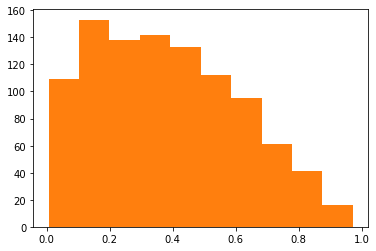

In [15]:
## simulate a generalized distribution
sim_n=1000
true_alpha,true_beta,true_loc,true_scale=1.4,2.2,0,1
sim_data = beta.rvs(true_alpha,true_beta,loc=true_loc,scale=true_scale,size=sim_n)
sim_bins2=plt.hist(sim_data)[1]
sim_probs2=plt.hist(sim_data)[0]/sim_n
sim_est=GeneralizedBetaEst(sim_bins2,sim_probs2)
sim_est

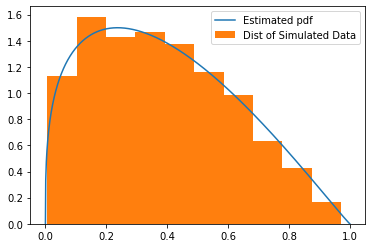

In [16]:
## plot the estimated generalized beta versus the histogram of simulated data drawn from a true beta distribution 
sim_x = np.linspace(true_loc,true_loc+true_scale,sim_n)
sim_pdf=beta.pdf(sim_x,sim_est[0],sim_est[1],loc=true_loc,scale=true_scale)
plt.plot(sim_x,sim_pdf,label='Estimated pdf')
plt.hist(sim_data,density=True,label='Dist of Simulated Data')
plt.legend(loc=0)

In [17]:
## This is the synthesized density estimation function
def SynDensityStat(bin,probs):
    """
    Synthesized density estimate module:
    It first detects the shape of histograms
    Then accordingly invoke the distribution-specific tool.
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    -------
    moments: dict with 2 keys (more to be added in future)
            mean: empty or float, estimated mean 
            variance:  empty or float, estimated variance 
            std: empty or float, estimated standard deviation 
            irq1090: empty or float, estimated irq1090 
    
    """
    if sum(probs)==1:
        print("probs sum up to 1")
        ## Check if all bins have the same probability (special case for which we need Uniform and not Beta distributions)
        all_pos = 0
        pos_bin = []
        # find non zero positions
        pos_entry = np.argwhere(probs!=0)
            
        for i in pos_entry:
            pos_bin.append(probs[i])
        pos_bin = np.hstack(pos_bin)   # clean    

        if len(pos_entry)>1:
            for i in range(len(pos_entry)-1) :
                if pos_entry[i+1] - pos_entry[i] !=1:
                    pos_bin = [] 
                
        if len(pos_bin)!=0:
            if np.all(pos_bin == pos_bin[0]):
                all_pos = 1
                
                
        ## Beta distributions 
        if sum([probs[i]>0 for i in range(len(bin)-1)])>=3 and all_pos == 0:
            print("at least three bins with positive probs")
            para_est=GeneralizedBetaEst(bin,probs)
            if len(para_est)==4:
                print('4 parameters')
                return GeneralizedBetaStats(para_est[0],para_est[1],para_est[2],para_est[3])
            if len(para_est)==2:
                print('2 parameters')
                return GeneralizedBetaStats(para_est[0],para_est[1],0,1)
        ## Triangle distributions
        if sum([probs[i]>0 for i in range(len(bin)-1)])==2 and all_pos == 0:
            #print("There are two bins with positive probs")
            pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
            if sum(pprobadj)>0:
                #print('The two intervals are adjacent and not open-ended')
                para_est=TriangleEst(bin,probs)
                return TriangleStats(para_est['lb'],para_est['ub'], para_est['mode'])
        ## Uniform distributions
        if sum([probs[i]>0 for i in range(len(bin)-1)])==1:
            print('Only one interval with positive probs')
            para_est= UniformEst(bin,probs)
            print(para_est)
            return UniformStats(para_est['lb'],para_est['ub'])
        if all_pos == 1:
            print("all bins have the same prob")
            para_est= UniformEst(bin,probs)
            print(para_est)
            return UniformStats(para_est['lb'],para_est['ub'])            
        else:
            return {"mean":[],"variance":[], "std":[], "irq1090":[]}
    else:
        return {"mean":[],"variance":[], "std":[], "irq1090":[]}

In [18]:
## testing the synthesized estimator function using an arbitrary example created above
SynDensityStat(sim_bins2,sim_probs2)['variance']
SynDensityStat(sim_bins2,sim_probs2)['irq1090']

probs sum up to 1
at least three bins with positive probs
lower bound is 0.006067883080042802
upper bound is 0.9720447458064242
4 parameters
probs sum up to 1
at least three bins with positive probs
lower bound is 0.006067883080042802
upper bound is 0.9720447458064242
4 parameters


0.12844702997720328

In [19]:
### loading probabilistic data  
IndSPF=pd.read_stata('../data/sample_data.dta')   
# SPF inflation quarterly 
# 2 Inf measures: CPI and PCE
# 2 horizons: y-1 to y  and y to y+1

In [20]:
## survey-specific parameters 
nobs=len(IndSPF)
SPF_bins=np.array([-10,0,0.5,1,1.5,2,2.5,3,3.5,4,10])
print("There are "+str(len(SPF_bins)-1)+" bins in SPF")

There are 10 bins in SPF


In [21]:
len({'mean':1,'var':2})

2

In [22]:
##############################################
### attention: the estimation happens here!!!!!
###################################################

#IndSPF['PRCCPIMean0']='nan'   # CPI from y-1 to y 
#IndSPF['PRCCPIVar0']='nan'    
#IndSPF['PRCCPIMean1']='nan'  # CPI from y to y+1  
#IndSPF['PRCCPIVar1']='nan'
#IndSPF['PRCPCEMean0']='nan' # PCE from y-1 to y
#IndSPF['PRCPCEVar0']='nan'
#IndSPF['PRCPCEMean1']='nan' # PCE from y to y+1
#IndSPF['PRCPCEVar1']='nan'


## creating positions 
index  = IndSPF.index
columns=['PRCCPIMean0','PRCCPIVar0', 'PRCCPIStd0','PRCCPIIrq10900',
         'PRCCPIMean1','PRCCPIVar1','PRCCPIStd1','PRCCPIIrq10901',
         'PRCPCEMean0','PRCPCEVar0','PRCPCEStd0','PRCPCEIrq10900',
         'PRCPCEMean1','PRCPCEVar1','PRCPCEStd1','PRCPCEIrq10901']
IndSPF_moment_est = pd.DataFrame(index=index,columns=columns)

## Invoking the estimation

for i in range(nobs):
    print(i)
    ## take the probabilities (flip to the right order, normalized to 0-1)
    PRCCPI_y0 = np.flip(np.array([IndSPF.iloc[i,:]['PRCCPI'+str(n)]/100 for n in range(1,11)]))
    print(PRCCPI_y0)
    PRCCPI_y1 = np.flip(np.array([IndSPF.iloc[i,:]['PRCCPI'+str(n)]/100 for n in range(11,21)]))
    print(PRCCPI_y1)
    PRCPCE_y0 = np.flip(np.array([IndSPF.iloc[i,:]['PRCPCE'+str(n)]/100 for n in range(1,11)]))
    print(PRCCPI_y0)
    PRCPCE_y1 = np.flip(np.array([IndSPF.iloc[i,:]['PRCPCE'+str(n)]/100 for n in range(11,21)]))
    print(PRCCPI_y1)
    if not np.isnan(PRCCPI_y0).any():
        stats_est=SynDensityStat(SPF_bins,PRCCPI_y0)
        if len(stats_est)>0:
            IndSPF_moment_est['PRCCPIMean0'][i]=stats_est['mean']
            print(stats_est['mean'])
            IndSPF_moment_est['PRCCPIVar0'][i]=stats_est['variance']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCCPIStd0'][i]=stats_est['std']
            print(stats_est['std'])
            IndSPF_moment_est['PRCCPIIrq10900'][i]=stats_est['irq1090']
            print(stats_est['irq1090'])            
    if not np.isnan(PRCCPI_y1).any():
        stats_est=SynDensityStat(SPF_bins,PRCCPI_y1)
        if len(stats_est):
            print(stats_est['mean'])
            IndSPF_moment_est['PRCCPIMean1'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCCPIVar1'][i]=stats_est['variance']
            print(stats_est['std'])
            IndSPF_moment_est['PRCCPIStd1'][i]=stats_est['std']
            print(stats_est['irq1090'])
            IndSPF_moment_est['PRCCPIIrq10901'][i]=stats_est['irq1090']
    if not np.isnan(PRCPCE_y0).any():
        if len(stats_est)>0:
            stats_est=SynDensityStat(SPF_bins,PRCPCE_y0)
            print(stats_est['mean'])
            IndSPF_moment_est['PRCPCEMean0'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCPCEVar0'][i]=stats_est['variance']
            print(stats_est['std'])
            IndSPF_moment_est['PRCPCEStd0'][i]=stats_est['std']
            print(stats_est['irq1090'])
            IndSPF_moment_est['PRCPCEIrq10900'][i]=stats_est['irq1090']
    if not np.isnan(PRCPCE_y1).any():
        if len(stats_est)>0:
            stats_est=SynDensityStat(SPF_bins,PRCPCE_y1)
            print(stats_est['mean'])
            IndSPF_moment_est['PRCPCEMean1'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCPCEVar1'][i]=stats_est['variance']
            print(stats_est['std'])
            IndSPF_moment_est['PRCPCEStd1'][i]=stats_est['std']
            print(stats_est['irq1090'])
            IndSPF_moment_est['PRCPCEIrq10901'][i]=stats_est['irq1090']

0
[0.  0.  0.  0.  0.  0.4 0.4 0.2 0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.4 0.2 0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
2 parameters
0.42703989182291147
0.06107098995339946
0.24712545387596047
0.1285285506029574
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5339485560023147
0.04583340869330193
0.21408738564731442
0.19901505366719574
[]
[]
[]
[]
[]
[]
[]
[]
1
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
2
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
3
[0.  0.  0.  0.  0.  0.2 0.7 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.2 0.6 0.2 0.  0. ]
[0. 

[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.05 0.25 0.4  0.2  0.05 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999973347073623
0.022979669905026805
0.15159046772481047
0.3065583307503693
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.4240649362269904
0.026561177596813836
0.1629760031317919
0.23033340125661542
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5649110079325329
0.029192076284620214
0.17085688831481222
0.29855843391425796
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.4528106737700618
0.028020587043179068
0.167393509561091
0.23981016199033253
15
[0.   0.   0.   0.01 0.09 0.4  0.4  0.09 0.01 0.  ]
[0.   0.   0.01 0.02 0.09 0.4  0.38 0.08 0.02 0.  ]
[0.   0.   0.   0.01 0.09 0.4  0.4  

[0.   0.02 0.03 0.2  0.5  0.2  0.03 0.02 0.   0.  ]
[0.   0.03 0.07 0.2  0.4  0.2  0.07 0.03 0.   0.  ]
[0.   0.02 0.03 0.2  0.5  0.2  0.03 0.02 0.   0.  ]
[0.   0.03 0.07 0.2  0.4  0.2  0.07 0.03 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5000018243694268
0.01203972830902545
0.10972569575548588
0.43086270161401263
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5000018243694268
0.01203972830902545
0.10972569575548588
0.43086270161401263
[]
[]
[]
[]
27
[0.   0.   0.05 0.1  0.2  0.3  0.2  0.1  0.05 0.  ]
[0.   0.03 0.07 0.1  0.15 0.25 0.2  0.15 0.05 0.  ]
[0.   0.   0.05 0.1  0.2  0.3  0.2  0.1  0.05 0.  ]
[0.   0.03 0.07 0.1  0.15 0.25 0.2  0.15 0.05 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.49999995066763175
0.0371544323450666
0.19275485038013077
0.21845964508

at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4834556458774596
0.039327358839709045
0.19831126755610495
0.20073109405721826
38
[0.   0.   0.   0.01 0.07 0.28 0.42 0.18 0.03 0.01]
[nan nan nan nan nan nan nan nan nan nan]
[0.   0.   0.   0.01 0.07 0.28 0.42 0.18 0.03 0.01]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-44.91786238587459
-156.96428947799012
nan
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
2 parameters
0.2206293619633958
0.0024833897873268846
0.04983362105373123
0.43176793054405693
39
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]

<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)



[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
40
[0.   0.   0.   0.05 0.35 0.45 0.15 0.   0.   0.  ]
[0.   0.   0.   0.05 0.35 0.4  0.2  0.   0.   0.  ]
[0.   0.   0.   0.05 0.35 0.45 0.15 0.   0.   0.  ]
[0.   0.   0.   0.05 0.35 0.4  0.2  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5482291008406536
0.03292173645741858
0.1814434800631276
0.26592848362129895
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5584269987115689
0.03923909636189176
0.19808860735007391
0.23761982956828384
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5062010540128709
0.029012496654592965
0.17033055114862092
0.26625887662129144
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4748791393365953
0.0405970222

2 parameters
0.5119576718738615
0.03532688728425942
0.18795448194778283
0.2335162875567535
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999987323683637
0.04817954323333004
0.2194983900472394
0.17722009996712362
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999677577079626
0.06405642688062488
0.2530937116576089
0.14161775761243797
56
[0.   0.   0.   0.   0.3  0.65 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.3  0.65 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.3  0.65 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.3  0.65 0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.41802526857077754
0.021112205618991863
0.14530039786246926
0.26539081322859065
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.41802526857077754
0.0

at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4431741848435198
0.029638839050540607
0.17215934203679045
0.22434069072361776
68
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.   0.   0.   0.   0.05 0.75 0.2  0.   0.   0.  ]
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.   0.   0.   0.   0.05 0.75 0.2  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49997967083811584
0.016198196310693986
0.12727213485556838
0.3740837251949655
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.552110134141557
0.016920032019643417
0.13007702341168256
0.3996260172112216
69
[0.   0.   0.02 0.06 0.1  0.25 0.3  0.15 0.1  0.02]
[0.   0.05 0.02 0.06 0.12 0.2  0.25 0.15 0.12 0.03]
[0.   0.   0.02 0.06 0.1  0.25 0.3  0.15 0.1  0.02]
[0.   0.05 0.02 0.06 0.12 0.2  0.25 0.15 0.12 0.03]
probs sum up to 1
at least three bins with positive

2 parameters
0.49999171328706654
0.012032833569954481
0.10969427318668228
0.43096383316928316
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.49999171328706654
0.012032833569954481
0.10969427318668228
0.43096383316928316
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.49999171328706654
0.012032833569954481
0.10969427318668228
0.43096383316928316
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.49999926737357536
0.016602847456869668
0.12885203706915024
0.3693288961289776
80
[0.   0.   0.   0.1  0.2  0.4  0.25 0.05 0.   0.  ]
[0.   0.   0.   0.1  0.2  0.35 0.25 0.1  0.   0.  ]
[0.   0.   0.   0.1  0.2  0.4  0.25 0.05 0.   0.  ]
[0.   0.   0.   0.1  0.2  0.35 0.25 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.495938124359147

<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


2 parameters
0.2206293619633958
0.0024833897873268846
0.04983362105373123
0.43176793054405693
91
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
92
[0.   0.   0.   0.   0.25 0.4  0.35 0.   0.   0.  ]
[0.   0.   0.   0.05 0.3  0.35 0.25 0.05 0.   0.  ]
[0.   0.   0.   0.   0.25 0.4  0.35 0.   0.   0.  ]
[0.   0.   0.   0.05 0.3  0.35 0.25 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5367256621020939
0.06486412194171783
0.25468435747355556
0.1493835760051457
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.48804831600177717
0.03533030249697541
0.1879635669404457
0.22072766412272962
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4632744223404396
0.06486719110130389
0

0.36891567369150635
0.0283024691884139
0.16823337715332798
0.18538049392679973
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.7405361848863923
0.09613088107781935
0.3100498041892937
0.4476778031825299
102
[0.  0.  0.3 0.3 0.4 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.2 0.4 0.4 0.  0.  0.  0. ]
[0.  0.  0.3 0.3 0.4 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.2 0.4 0.4 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5405835108276622
0.09202602739246106
0.30335791961387965
0.11950593751066022
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.572962059964443
0.06106547044579695
0.24711428620336168
0.16710913264602026
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5562651286984547
0.07953245578716357
0.2820149921319141
0.1315626328996405
prob

2 parameters
0.49997967083811584
0.016198196310693986
0.12727213485556838
0.3740837251949655
[]
[]
[]
[]
118
[0.   0.   0.02 0.06 0.1  0.3  0.25 0.15 0.1  0.02]
[0.   0.05 0.02 0.06 0.12 0.2  0.25 0.15 0.12 0.03]
[0.   0.   0.02 0.06 0.1  0.3  0.25 0.15 0.1  0.02]
[0.   0.05 0.02 0.06 0.12 0.2  0.25 0.15 0.12 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
2 parameters
0.22171338237866683
0.005514899522594401
0.07426236949218898
0.29318187820272457
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.26034933256064385
0.007598202129662496
0.08716766676734267
0.2910660407899651
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
2 parameters
0.21541070677254404
0.0058930731015190896
0.07676635396786205
0.273013337389111
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.

0.19275485038013077
0.2184596450828473
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.23119322485199342
0.008875372521951544
0.09420919552756803
0.23011517701784517
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5159814824956075
0.02785879569439198
0.1669095434491149
0.2797183058769143
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.22014231522737773
0.0073647276388852725
0.08581799134730009
0.24427996120924117
130
[0.  0.  0.  0.  0.3 0.4 0.3 0.  0.  0. ]
[0.   0.   0.05 0.1  0.25 0.35 0.2  0.05 0.   0.  ]
[0.  0.  0.  0.  0.3 0.4 0.3 0.  0.  0. ]
[0.   0.   0.05 0.1  0.25 0.35 0.2  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5000016564689075
0.06615015767980431
0.2571967295278156
0.13841249694368563
probs sum up 

0.49999999258478184
0.013834432648520049
0.11761986502508855
0.40444174719047665
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.5228463576412457
0.023974647171020085
0.1548374863236293
0.3128475329088351
143
[0.  0.  0.  0.  0.1 0.6 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.5 0.4 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.6 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.5 0.4 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5649110079325329
0.029192076284620214
0.17085688831481222
0.29855843391425796
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.6000420717951156
0.03684152091257669
0.1919414517830286
0.26941934212116175
144
[0.   0.   0.   0.   0.05 0.6  0.3  0.05 0.   0.  ]
[0.   0.   0.   0.02 0.2  0.55 0.2  0.03 0.   0.  ]
[0.   0.   0.   0.   0.05 0.6  0.3  0.05 0.   0.  ]
[0.   0.   0.   0.02 0.2

0.3030029234776083
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4653473690691878
0.02540710143971754
0.1593960521459598
0.265186273537167
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999973347073623
0.022979669905026805
0.15159046772481047
0.3065583307503693
[]
[]
[]
[]
157
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
158
[0.01 0.01 0.01 0.01 0.1  0.74 0.1  0.01 0.01 0.  ]
[0.01 0.01 0.01 0.02 0.25 0.5  0.15 0.03 0.01 0.01]
[0.01 0.01 0.01 0.01 0.1  0.74 0.1  0.01 0.01 0.  ]
[0.01 0.01 0.01 0.02 0.25 0.5  0.15 0.03 0.01 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
-0.6126724771432053
0.002405428061149673
0.04904516348376946
nan
probs sum up to 1
at least three bi

<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)



lower bound is 1.5
upper bound is 3.0
2 parameters
0.34999371827155795
0.03109699113387592
0.17634338982189246
0.16279375925458786
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
2 parameters
0.20785173219964684
0.003751956463586557
0.061253215944851065
0.3378537465433439
168
[0.   0.   0.   0.02 0.12 0.68 0.17 0.01 0.   0.  ]
[0.   0.   0.01 0.02 0.29 0.36 0.29 0.02 0.01 0.  ]
[0.   0.   0.   0.02 0.12 0.68 0.17 0.01 0.   0.  ]
[0.   0.   0.01 0.02 0.29 0.36 0.29 0.02 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5080901659458547
0.009668318595951391
0.09832760851333358
0.47717691722353356
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5000034356967868
0.017010642221950978
0.1304248527771873
0.3646390964739338
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound 

[0.   0.02 0.08 0.12 0.15 0.25 0.15 0.12 0.1  0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.49999995066763175
0.0371544323450666
0.19275485038013077
0.2184596450828473
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.23119322485199342
0.008875372521951544
0.09420919552756803
0.23011517701784517
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5159814824956075
0.02785879569439198
0.1669095434491149
0.2797183058769143
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.22014231522737773
0.0073647276388852725
0.08581799134730009
0.24427996120924117
178
[0.  0.  0.  0.  0.1 0.2 0.3 0.3 0.1 0. ]
[0.  0.  0.  0.  0.1 0.2 0.3 0.3 0.1 0. ]
[0.  0.  0.  0.  0.1 0.2 0.3 0.3 0.1 0. ]
[0.  0.  0.  0.  0.1 0.2 0.3 0.3 0.1 0. ]
[]
[]
[]
[]
[]
[]
[]

<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


4 parameters
2.5884930201025753
0.5827731274140847
0.7633957868721079
0.7594836008472996
187
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
188
[0.   0.   0.   0.   0.1  0.65 0.25 0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.2  0.45 0.2  0.05 0.  ]
[0.   0.   0.   0.   0.1  0.65 0.25 0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.2  0.45 0.2  0.05 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5487663864446187
0.025724646616226962
0.16038904768165113
0.3145940266974855
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 4.0
2 parameters
0.48490658843284346
0.031336509215778734
0.1770212112030045
0.2397439040427166
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.3863068152076197
0.025731505349748773
0.

0.4727584528320167
0.03461385893793222
0.18604800170367922
0.21585986685570188
198
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49997967083811584
0.016198196310693986
0.12727213485556838
0.3740837251949655
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0.23714926302365408
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.052758056251845
0.0509235781252197
0.22566253150494367
nan
199
[0.02 0.03 0.04 0.1  0.2  0.35 0.18 0.05 0.02 0.01]
[0.01 0

2 parameters
0.4999989481792777
0.03166214601422545
0.17793860181035887
0.24659291716853954
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4999989481792777
0.03166214601422545
0.17793860181035887
0.24659291716853954
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5483532027843137
0.03503499366579699
0.18717637047928082
0.2540760554625947
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.48804831600177717
0.03533030249697541
0.1879635669404457
0.22072766412272962
211
[0.   0.   0.   0.01 0.08 0.38 0.43 0.08 0.02 0.  ]
[0.   0.   0.   0.03 0.11 0.36 0.34 0.13 0.03 0.  ]
[0.   0.   0.   0.01 0.08 0.38 0.43 0.08 0.02 0.  ]
[0.   0.   0.   0.03 0.11 0.36 0.34 0.13 0.03 0.  ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.5027405781

<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


2 parameters
0.20785173219964684
0.003751956463586557
0.061253215944851065
0.3378537465433439
214
[0.   0.   0.   0.01 0.06 0.23 0.36 0.3  0.03 0.01]
[0.   0.   0.   0.01 0.06 0.23 0.38 0.28 0.03 0.01]
[0.   0.   0.   0.01 0.06 0.23 0.36 0.3  0.03 0.01]
[0.   0.   0.   0.01 0.06 0.23 0.38 0.28 0.03 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-33.02954501872108
-67.08289585119046
nan
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-33.94734206578234
-72.25693145668197
nan
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5708577117578297
0.023599516599180095
0.15362134161365762
0.34463994521840646
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5708577117578297
0.023599516599180095
0.15362134161365762

<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)



0.34463994521840646
215
[0.   0.   0.05 0.1  0.5  0.2  0.1  0.05 0.   0.  ]
[0.   0.05 0.1  0.2  0.5  0.1  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.1  0.5  0.2  0.1  0.05 0.   0.  ]
[0.   0.05 0.1  0.2  0.5  0.1  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.46527749182932693
0.02174069991307321
0.14744727841867142
0.2937959478584398
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.5347300719580572
0.021738948751952963
0.1474413400371584
0.33942505819583957
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.5442547522551456
0.019794081606453042
0.14069144112721654
0.363850966099763
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.3648590562240934
0.029142888194853275
0.17071288233420837
0.1790703663342921
216
[0.  0.  0. 

[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
226
[0.018 0.018 0.02  0.046 0.092 0.137 0.184 0.183 0.137 0.165]
[0.018 0.018 0.02  0.046 0.092 0.137 0.184 0.183 0.137 0.165]
[0.018 0.018 0.02  0.046 0.092 0.137 0.184 0.183 0.137 0.165]
[0.018 0.018 0.02  0.046 0.092 0.137 0.184 0.183 0.137 0.165]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.898413332369574
1.1692481876161467
1.0813178013961235
0.6395607876968482
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.898413332369574
1.1692481876161467
1.0813178013961235
0.6395607876968482
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.817672959268556
1.0978781488695264
1.0477968070525536
0.7036508776175372
probs sum up to 1
at least three bins with positive probs
low

[0.   0.05 0.1  0.15 0.2  0.2  0.15 0.1  0.05 0.  ]
[0.   0.   0.05 0.15 0.3  0.3  0.15 0.05 0.   0.  ]
[0.   0.05 0.1  0.15 0.2  0.2  0.15 0.1  0.05 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5000000204045739
0.03550278434480547
0.1884218255532131
0.2262865778894619
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.4999996249971417
0.04786940765010275
0.21879078511240538
0.1781586435896878
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5000000204045739
0.03550278434480547
0.1884218255532131
0.2262865778894619
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.4999996249971417
0.04786940765010275
0.21879078511240538
0.1781586435896878
240
[0.  0.  0.5 0.4 0.1 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.5 0.4 0.1 0.  0.  0.  0. ]
[0.  0.  0

2 parameters
0.5329447838645541
0.02250029165123265
0.15000097216762515
0.33153666536926096
250
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
251
[0.   0.   0.   0.   0.   0.05 0.75 0.2  0.   0.  ]
[0.   0.   0.   0.   0.   0.   0.25 0.7  0.05 0.  ]
[0.   0.   0.   0.   0.   0.05 0.75 0.2  0.   0.  ]
[0.   0.   0.   0.   0.   0.   0.25 0.7  0.05 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
2 parameters
0.552110134141557
0.016920032019643417
0.13007702341168256
0.3996260172112216
probs sum up to 1
at least three bins with positive probs
lower bound is 2.5
upper bound is 4.0
2 parameters
0.4329800247463089
0.018972346237490605
0.13774014025508544
0.29573783826342054
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.5
0.041666666666666664
0.20412414523193

2 parameters
0.12997681968991145
0.006260201218205632
0.07912143336799221
0.1453959394358659
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 4.0
2 parameters
0.39650914622845057
0.030541685869628687
0.1747617975120097
0.19149557616736318
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5374673934476418
0.02115645390792274
0.14545258302251884
0.34648430927238627
264
[0.   0.   0.   0.01 0.18 0.4  0.34 0.06 0.01 0.  ]
[0.   0.   0.01 0.02 0.24 0.34 0.29 0.09 0.01 0.  ]
[0.   0.   0.   0.01 0.18 0.4  0.34 0.06 0.01 0.  ]
[0.   0.   0.01 0.02 0.24 0.34 0.29 0.09 0.01 0.  ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5258055703126934
0.020588206990967136
0.1434859121689901
0.3445067505296034
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.43663202

upper bound is 3.0
2 parameters
0.5649110079325329
0.029192076284620214
0.17085688831481222
0.29855843391425796
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5649110079325329
0.029192076284620214
0.17085688831481222
0.29855843391425796
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.46604885466652757
0.04583547859463797
0.21409221983677496
0.17029896246017737
279
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
280
[0.   0.   0.   0.   0.   0.35 0.65 0.   0.   0.  ]
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
[0.   0.   0.   0.   0.   0.35 0.65 0.   0.   0.  ]
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.3878430852653993
0.06245601470956405


at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.36891567369150635
0.0283024691884139
0.16823337715332798
0.18538049392679973
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.41807519908523183
0.03283112306150529
0.1811936065690655
0.193572334364346
291
[0.   0.   0.02 0.02 0.04 0.07 0.22 0.24 0.23 0.16]
[0.   0.   0.   0.01 0.03 0.08 0.24 0.25 0.22 0.17]
[0.   0.   0.02 0.02 0.04 0.07 0.22 0.24 0.23 0.16]
[0.   0.   0.   0.01 0.03 0.08 0.24 0.25 0.22 0.17]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
2 parameters
0.29367469901360327
0.006805275555515334
0.08249409406445611
0.35082232657117374
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
0.2580555400674928
0.006631347385722216
0.0814330853260652
0.31153833370620077
probs sum up to 1
at least three bins with positive 

2 parameters
0.4329800247463089
0.018972346237490605
0.13774014025508544
0.29573783826342054
303
[0.   0.   0.   0.   0.03 0.4  0.5  0.07 0.   0.  ]
[0.   0.   0.   0.1  0.35 0.4  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.03 0.4  0.5  0.07 0.   0.  ]
[0.   0.   0.   0.1  0.35 0.4  0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.5268715000705443
0.022371130493403356
0.1495698181231874
0.3288882896297927
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5251241571539853
0.040596496417230364
0.20148572261386255
0.2156749940813686
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.49999973347073623
0.022979669905026805
0.15159046772481047
0.3065583307503693
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999245279459364
0.

probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4834556458774596
0.039327358839709045
0.19831126755610495
0.20073109405721826
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.46604885466652757
0.04583547859463797
0.21409221983677496
0.17029896246017737
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4834556458774596
0.039327358839709045
0.19831126755610495
0.20073109405721826
317
[0.   0.   0.   0.   0.05 0.9  0.05 0.   0.   0.  ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.05 0.9  0.05 0.   0.   0.  ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5000316376487521
0.010195805923988175
0.10097428347845888
0.4619423139667206
probs sum up to 1
all bins have the same prob
length 

lower bound is 1.0
upper bound is 3.5
2 parameters
0.4531192866372092
0.04381458312011671
0.2093193328866608
0.1708106295059385
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.44782138606567085
0.016896341243014052
0.12998592709602855
0.3284494060222524
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5442547522551456
0.019794081606453042
0.14069144112721654
0.363850966099763
330
[0.   0.   0.   0.   0.05 0.65 0.3  0.   0.   0.  ]
[0.   0.   0.   0.   0.   0.25 0.75 0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.65 0.3  0.   0.   0.  ]
[0.   0.   0.   0.   0.   0.25 0.75 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5819652349833171
0.021117564873080606
0.1453188386723504
0.3734057125564986
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not o

probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5251387064888484
0.038590929313859997
0.1964457413991456
0.22456105475749333
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.48378509313179135
0.027851001256316153
0.1668861925274711
0.2602268125686724
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5341281557966403
0.03174000796438507
0.17815725627766352
0.2652995740297989
341
[0.  0.  0.  0.  0.3 0.6 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.6 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.46604885466652757
0.04583547859463797
0.21409221983677496
0.17029896246017737
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive 

<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


2 parameters
0.5000316376487521
0.010195805923988175
0.10097428347845888
0.4619423139667206
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4796479914678939
0.012688147745788036
0.11264167854656656
0.40649344437095847
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5000316376487521
0.010195805923988175
0.10097428347845888
0.4619423139667206
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4796479914678939
0.012688147745788036
0.11264167854656656
0.40649344437095847
349
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.  0.2 0.5 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.  0.2 0.5 0.3 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0

probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.552758056251845
0.05092357812521965
0.2256625315049436
0.47915965543764527
361
[0.   0.   0.   0.   0.   0.15 0.85 0.   0.   0.  ]
[0.   0.   0.   0.   0.2  0.38 0.25 0.1  0.05 0.02]
[0.   0.   0.   0.   0.   0.15 0.85 0.   0.   0.  ]
[0.   0.   0.   0.   0.2  0.38 0.25 0.1  0.05 0.02]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.591971078052723
0.027747933524242888
0.16657710984478896
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 10.0
2 parameters
0.11627360234313742
0.004483707493395204
0.06696049203370003
0.15540334585271526
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.3778711402938207
0.02074327671281999
0.14402526414771816
0.23826627296512054
[]
[]
[]
[]
362
[0.   0.   0.   0.   0.02 0.26 0.62 0.0

0.5000009070236492
0.02229788135337052
0.1493247513085842
0.31233846855872194
372
[0.  0.  0.  0.  0.1 0.6 0.3 0.  0.  0. ]
[0.   0.05 0.1  0.3  0.25 0.2  0.1  0.   0.   0.  ]
[0.  0.  0.  0.  0.1 0.6 0.3 0.  0.  0. ]
[0.   0.05 0.1  0.3  0.25 0.2  0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5649110079325329
0.029192076284620214
0.17085688831481222
0.29855843391425796
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0.23714926302365408
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.4570331981896878
0.04630269806917948
0.21518061731759083
0.16527282767039347
373
[0.  0.  0.  0.  0.1 0.9 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.9 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.4 0

384
[0.   0.   0.   0.   0.   0.47 0.53 0.   0.   0.  ]
[0.   0.   0.   0.08 0.5  0.4  0.02 0.   0.   0.  ]
[0.   0.   0.   0.   0.   0.47 0.53 0.   0.   0.  ]
[0.   0.   0.   0.08 0.5  0.4  0.02 0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.2049219528112713
0.10535818352024028
0.32458925355014495
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4679750906907767
0.022590575586550577
0.1503016153823723
0.288509036481369
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.7950780471887287
0.10535818352024028
0.32458925355014495
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.43581612130368563
0.015365952334559823
0.12395947859909634
0.33710395065528376
385
[0.005 0.015 0.03  0.05  0.25  0.35  0.25  0.03  0.015 0.005]
[0.02 

probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.6236339461634768
0.0035597511847145686
0.05966365044744219
0.6958640874637512
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8375171851308387
0.001048173846388063
0.03237551306756486
0.8641900677384201
395
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
396
[0.  0.  0.  0.  0.  0.8 0.2 0.  0.  0. ]
[0.   0.   0.   0.05 0.75 0.2  0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.  0.8 0.2 0.  0.  0. ]
[0.   0.   0.   0.05 0.75 0.2  0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.4522542485937366
0.03408898422851436
0.1846320238434123
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound

2 parameters
0.5611865957950172
0.02192571449961974
0.14807334162373637
0.3537721979873207
410
[0.   0.   0.25 0.55 0.2  0.   0.   0.   0.   0.  ]
[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0. ]
[0.   0.   0.25 0.55 0.2  0.   0.   0.   0.   0.  ]
[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.4834556458774596
0.039327358839709045
0.19831126755610495
0.20073109405721826
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0.23714926302365408
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.4834556458774596
0.039327358839709045
0.19831126755610495
0.20073109405721826
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.3802911891044355
0.041188678611817096
0

0.5000009070236492
0.02229788135337052
0.1493247513085842
0.31233846855872194
421
[0.2 0.5 0.3 0.  0.  0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.6 0.4 0.  0.  0.  0. ]
[0.2 0.5 0.3 0.  0.  0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.6 0.4 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 1.0
2 parameters
-0.29935313671042185
0.0009615966848252618
0.031009622455380876
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.180189805014032
0.07710969514083763
0.27768632508792657
nan
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 1.0
2 parameters
-0.28735533220169196
0.0007677265077541003
0.027707878081045835
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.572962059964443
0.06106547044579695
0.24711428620336168
0.16710913264602026
422
[0.5 0.5 0.  0.  0.  0.  0.  0. 

probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5983237799382989
0.04847181616992285
0.2201631580667457
0.21468854168446924
433
[0.25 0.25 0.5  0.   0.   0.   0.   0.   0.   0.  ]
[0.   0.   0.25 0.5  0.25 0.   0.   0.   0.   0.  ]
[0.25 0.25 0.5  0.   0.   0.   0.   0.   0.   0.  ]
[0.   0.   0.25 0.5  0.25 0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 1.0
2 parameters
-0.28610773405152584
0.0008073615522396514
0.02841410833089174
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.49999636558725735
0.04692359411065275
0.21661854516788895
0.18108944570706106
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 1.5
2 parameters
0.49999636558725735
0.04692359411065275
0.21661854516788895
0.18108944570706106
probs sum up to 1
at least three bins with po

<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 4.0
2 parameters
0.4063341175178302
0.03453311714238453
0.18583088317710952
0.18003825763086498
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-96.3709279102125
-1351.3549574346084
nan
nan
446
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
447
[0.01 0.01 0.05 0.35 0.5  0.05 0.01 0.01 0.01 0.  ]
[0.01 0.01 0.05 0.1  0.42 0.32 0.05 0.02 0.01 0.01]
[0.01 0.01 0.05 0.35 0.5  0.05 0.01 0.01 0.01 0.  ]
[0.01 0.01 0.05 0.1  0.42 0.32 0.05 0.02 0.01 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8250489167962729
0.0005974753927884268
0.024443309775650818
0.8943794784677292
probs sum up to 1
at least three bins with positive probs
lower bound is -10

2 parameters
0.4371194915267593
0.02867949255509424
0.16935020683510912
0.2260267298415484
457
[0.  0.  0.1 0.8 0.1 0.  0.  0.  0.  0. ]
[0.  0.1 0.7 0.2 0.  0.  0.  0.  0.  0. ]
[0.  0.  0.1 0.8 0.1 0.  0.  0.  0.  0. ]
[0.  0.1 0.7 0.2 0.  0.  0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.49997967083811584
0.016198196310693986
0.12727213485556838
0.3740837251949655
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 1.5
2 parameters
0.5329447838645541
0.02250029165123265
0.15000097216762515
0.33153666536926096
458
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.25 0.5  0.25 0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.25 0.5  0.25 0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999636558725735
0.04692359411065275

2 parameters
0.8649558773325283
0.003544467288292594
0.05953542884948923
0.7681371925988987
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.46042851278420555
0.050073575726822195
0.223771257597624
0.15693207547328844
469
[0.  0.  0.3 0.5 0.2 0.  0.  0.  0.  0. ]
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.  0.  0.3 0.5 0.2 0.  0.  0.  0.  0. ]
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.46604885466652757
0.04583547859463797
0.21409221983677496
0.17029896246017737
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999636558725735
0.04692359411065275
0.21661854516788895
0.18108944570706106
470
[0.   0.   0.   0.55 0.45 0.   0.   0.   0.   0.  ]
[nan nan nan nan nan nan nan nan nan nan]
[0.   0.   0.   0.55 0.45 0.   0.   0.   0.   0.  ]


probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.4601072293954327
0.042783242699169374
0.20684110495539657
0.1771252245656714
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8069905291689459
0.0026105494303034923
0.051093536091207196
0.7862117629010172
481
[0.   0.   0.05 0.7  0.2  0.05 0.   0.   0.   0.  ]
[0.  0.  0.  0.2 0.7 0.1 0.  0.  0.  0. ]
[0.   0.   0.05 0.7  0.2  0.05 0.   0.   0.   0.  ]
[0.  0.  0.  0.2 0.7 0.1 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.4251887343520803
0.012152503373525336
0.11023839337329502
0.37269729420473874
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5329447838645541
0.02250029165123265
0.15000097216762515
0.33153666536926096
[]
[]
[]
[]
482
[0.   0.   0.45 0.55 0.

at least three bins with positive probs
lower bound is -10.0
upper bound is 1.5
2 parameters
0.9193745979890733
0.0017371156911670936
0.04167871988397789
0.8415898924145352
494
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
[0.   0.   0.25 0.6  0.15 0.   0.   0.   0.   0.  ]
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
[0.   0.   0.25 0.6  0.15 0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0.23714926302365408
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.4674728780774345
0.03235618425128615
0.17987824841065733
0.2241404830928238
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.48325708115910354
0.02218837862773952
0.14895764038054415
0.3021985641444891
probs sum up to 1
at least three bins with positive probs
lower bound i

0.17313094755566533
0.22470814198460642
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.40779694068832273
0.0409188854246265
0.20228416998031878
0.15950622293852496
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.43878537515873994
0.01643913298089193
0.12821518233380916
0.3267387301493949
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.42602722044467406
0.031793401026551
0.17830704143850012
0.20292428796514583
505
[0.   0.   0.   0.45 0.55 0.   0.   0.   0.   0.  ]
[0.   0.   0.45 0.55 0.   0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.45 0.55 0.   0.   0.   0.   0.  ]
[0.   0.   0.45 0.55 0.   0.   0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.2405361848863923
0.09613088107781932
0.3100498041892936
0.36372615783256396


[0.   0.   0.   0.   0.2  0.55 0.25 0.   0.   0.  ]
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.2  0.55 0.25 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999636558725735
0.04692359411065275
0.21661854516788895
0.18108944570706106
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5165451801524337
0.039327194860941196
0.19831085411782481
0.21703075091763166
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.46604885466652757
0.04583547859463797
0.21409221983677496
0.17029896246017737
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.46604885466652757
0.04583547859463797
0.21409221983677496
0.17029896246017737
519
[0.  0.6 0.4 0.  0.  0.  0.  0.  0.  0. ]
[0.  0.  0.3 0.4 0.3 0.  0.  0.  0.  0. ]


[0.   0.   0.05 0.25 0.3  0.3  0.1  0.   0.   0.  ]
[0.   0.   0.05 0.3  0.3  0.25 0.1  0.   0.   0.  ]
[0.   0.   0.05 0.25 0.3  0.3  0.1  0.   0.   0.  ]
[]
[]
[]
[]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 4.0
2 parameters
0.39909519944849525
0.04047766237666654
0.20119061204903807
0.1569452127535503
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.4946515956790427
0.04365958513515027
0.208948761985206
0.1896682751232881
530
[0.8 0.2 0.  0.  0.  0.  0.  0.  0.  0. ]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
[0.8 0.2 0.  0.  0.  0.  0.  0.  0.  0. ]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
probs sum up to 1
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9998996811344245
0.48088275499735517
0.6934571039345946
0.6113047322487111
probs sum up to 1
[]
[]
[]
[]
probs 

0.5710502302561512
0.03467001084558063
0.18619884759466324
0.26762881038659325
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.48325708115910354
0.02218837862773952
0.14895764038054415
0.3021985641444891
542
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0.  0.  0.2 0.5 0.3 0.  0.  0.  0.  0. ]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0.  0.  0.2 0.5 0.3 0.  0.  0.  0.  0. ]
probs sum up to 1
Only one interval with positive probs
length pos bins is 1
{'lb': 1.5, 'ub': 2.0}
1.75
0.020833333333333332
0.14433756729740643
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5339485560023147
0.04583340869330193
0.21408738564731442
0.19901505366719574
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.447241943748155
0.05092357812521967
0.22566253150494361
0.471764682736509
probs sum up to 1
at least three bins with positive probs
lo

0.19289734373206882
0.19263591544931896
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.516746769887581
0.02219961883992517
0.14899536516256193
0.3239984258432706
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.6000420717951156
0.03684152091257669
0.1919414517830286
0.26941934212116175
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4674728780774345
0.03235618425128615
0.17987824841065733
0.2241404830928238
555
[0.   0.   0.05 0.85 0.1  0.   0.   0.   0.   0.  ]
[0.   0.1  0.25 0.35 0.2  0.1  0.   0.   0.   0.  ]
[0.   0.   0.05 0.85 0.1  0.   0.   0.   0.   0.  ]
[0.   0.1  0.25 0.35 0.2  0.1  0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5203516554241453
0.012687953321058229
0.1126408155202111
0.43473732731445186


[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
2 parameters
0.6000420717951156
0.03684152091257669
0.1919414517830286
0.26941934212116175
567
[0.  0.  0.1 0.3 0.4 0.2 0.  0.  0.  0. ]
[0.  0.1 0.3 0.4 0.2 0.  0.  0.  0.  0. ]
[0.  0.  0.1 0.3 0.4 0.2 0.  0.  0.  0. ]
[0.  0.1 0.3 0.4 0.2 0.  0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5514332804171768
0.045224501868726716
0.21266053199577659
0.20868936236578264
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.5514332804171768
0.045224501868726716
0.21266053199577659
0.20868936236578264
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.8806089047243579
0.0015979846275069015
0.03997479990577691
0.841886257003575
probs sum up to 1
at least three bins with positive probs
low

2 parameters
0.43940101338863935
0.0345008662684042
0.18574408811158485
0.19807387993228937
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.5916336400419677
0.028286330941534935
0.16818540644638266
0.3192801836295719
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
-0.42624359525893013
0.0014160732287572238
0.03763074844800757
nan
[]
[]
[]
[]
580
[0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
[0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
[0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
[0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 0.5, 'ub': 1.5}
1.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 0.0, 'ub': 1.0}
0.5
0.08333333333333333
0.28867513459481287
9.0
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
u

[0.  0.  0.  0.1 0.5 0.4 0.  0.  0.  0. ]
[0.  0.  0.  0.4 0.6 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.1 0.5 0.4 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.3198101949859684
0.07710969514083776
0.2776863250879268
0.41186137233074477
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6000420717951156
0.03684152091257669
0.1919414517830286
0.26941934212116175
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.6413173137877248
0.04589167285009939
0.2142234180711796
0.2409242039342423
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6000420717951156
0.03684152091257669
0.1919414517830286
0.26941934212116175
591
[0.  0.  0.2 0.5 0.3 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.2 0.5 0.3 0.  0.  0.  0.  0. ]

probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.4640849723457787
0.033344232156008194
0.18260403105081824
0.21720410231341367
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.47715471000549836
0.02397555954662905
0.1548404325317811
0.2835935454062397
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.4869859128619385
0.043239297168630064
0.20794060971496178
0.187698218394906
602
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.2 0.6 0.2 0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.2 0.6 0.2 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0.23714926302365408
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0

probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9998996811344245
0.48088275499735517
0.6934571039345946
0.6113047322487111
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9998996811344245
0.48088275499735517
0.6934571039345946
0.6113047322487111
612
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
613
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
614
[0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.1  0.35 0.45 0.05 0.   0.  ]
[0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.1  0.35 0.45 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bo

625
[0.   0.   0.55 0.45 0.   0.   0.   0.   0.   0.  ]
[0.  0.  0.  0.2 0.5 0.3 0.  0.  0.  0. ]
[0.   0.   0.55 0.45 0.   0.   0.   0.   0.   0.  ]
[0.  0.  0.  0.2 0.5 0.3 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.2594638151136077
0.09613088107781938
0.31004980418929373
0.3686364742710242
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5339485560023147
0.04583340869330193
0.21408738564731442
0.19901505366719574
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
0.7405361848863923
0.09613088107781936
0.3100498041892937
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5339485560023147
0.04583340869330193
0.21408738564731442
0.19901505366719574
626
[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0. ]
[0.   0.   0.   0.18 0.6  0.22 0

0.31052973840575354
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 4.0
2 parameters
0.44524048964500007
0.048233326365486655
0.21962086960370286
0.15570871608613934
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4667874034269655
0.019996235572499313
0.1414080463499136
0.31052973840575354
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.44524048964500007
0.048233326365486655
0.21962086960370286
0.15570871608613934
637
[0.  0.1 0.4 0.4 0.1 0.  0.  0.  0.  0. ]
[0.05 0.1  0.3  0.35 0.2  0.   0.   0.   0.   0.  ]
[0.  0.1 0.4 0.4 0.1 0.  0.  0.  0.  0. ]
[0.05 0.1  0.3  0.35 0.2  0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.49999245279459364
0.03483981049615056
0.18665425389245904
0.22956972204278805
probs sum up to 1
at least thre

[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
649
[0.    0.05  0.125 0.2   0.25  0.2   0.125 0.05  0.    0.   ]
[0.05  0.125 0.2   0.25  0.2   0.125 0.05  0.    0.    0.   ]
[0.    0.05  0.125 0.2   0.25  0.2   0.125 0.05  0.    0.   ]
[0.05  0.125 0.2   0.25  0.2   0.125 0.05  0.    0.    0.   ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4999990181198754
0.043822636224019176
0.2093385684101694
0.1914798424046647
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
0.8612907250295735
0.0037449763637995796
0.06119621200531598
0.7614545006810223
650
[0.1652 0.252  0.3244 0.1728 0.0596 0.0204 0.0044 0.0008 0.0004 0.    ]
[0.1476 0.0956 0.1232 0.1552 0.1456 0.1284 0.096  0.0536 0.028  0.0268]
[0.1652 0.252  0.3244 0.1728 0.0596 0.0204 0.0044 0.0008 0.0004 0.    ]
[0.1476 0.0956 0.1232 0.

2 parameters
0.8854831176484018
0.0013765628514216537
0.037102059935017806
0.8532674074773673
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.8854831176484018
0.0013765628514216537
0.037102059935017806
0.8532674074773673
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.8854831176484018
0.0013765628514216537
0.037102059935017806
0.8532674074773673
662
[0.   0.05 0.5  0.4  0.05 0.   0.   0.   0.   0.  ]
[0.01 0.05 0.35 0.45 0.1  0.04 0.   0.   0.   0.  ]
[0.   0.05 0.5  0.4  0.05 0.   0.   0.   0.   0.  ]
[0.01 0.05 0.35 0.45 0.1  0.04 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.48325708115910354
0.02218837862773952
0.14895764038054415
0.3021985641444891
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.885829072

0.49997967083811584
0.016198196310693986
0.12727213485556838
0.3740837251949655
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.41807519908523183
0.03283112306150529
0.1811936065690655
0.193572334364346
672
[0.  0.  0.8 0.2 0.  0.  0.  0.  0.  0. ]
[0.   0.   0.25 0.6  0.15 0.   0.   0.   0.   0.  ]
[0.  0.  0.8 0.2 0.  0.  0.  0.  0.  0. ]
[0.   0.   0.25 0.6  0.15 0.   0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
0.9522542485937369
0.03408898422851428
0.18463202384341207
0.4252966546525125
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.4674728780774345
0.03235618425128615
0.17987824841065733
0.2241404830928238
673
[0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
[0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
[0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
[0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. 

[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
685
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
686
[4.880e-02 2.044e-01 5.028e-01 1.920e-01 4.560e-02 6.000e-03 4.000e-04
 0.000e+00 0.000e+00 0.000e+00]
[0.1016 0.0836 0.1284 0.1744 0.16   0.14   0.1056 0.0588 0.0268 0.0208]
[4.880e-02 2.044e-01 5.028e-01 1.920e-01 4.560e-02 6.000e-03 4.000e-04
 0.000e+00 0.000e+00 0.000e+00]
[0.1016 0.0836 0.1284 0.1744 0.16   0.14   0.1056 0.0588 0.0268 0.0208]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.5497254462780865
1.3346793228948828
1.1552832219394873
0.4378571017087159
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.43664060906743124
0.01216324327682062

[0.1  0.4  0.45 0.05 0.   0.   0.   0.   0.   0.  ]
[0.   0.03 0.95 0.02 0.   0.   0.   0.   0.   0.  ]
[0.1  0.4  0.45 0.05 0.   0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 1.5
2 parameters
0.49263276801325573
0.00726875194924621
0.08525697595649408
0.5177746082061392
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 1.5
2 parameters
0.9100878587406568
0.0009548166248516121
0.030900107198060207
0.8795588256933242
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 0.5, 'ub': 1.5}
1.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 1.5
2 parameters
0.9100878587406568
0.0009548166248516121
0.030900107198060207
0.8795588256933242
699
[0.   0.05 0.9  0.05 0.   0.   0.   0.   0.   0.  ]
[0.01 0.08 0.16 0.36 0.25 0.12 0.02 0.   0.   0.  ]
[0.   0.05 0.9  0.05 0. 

0.3976618289956912
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.4963968985255343
0.01689878374836599
0.12999532202493286
0.36343655772659667
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.49999798440089516
0.017886067923427527
0.1337388048526961
0.35492322697626044
708
[0.  0.  0.  0.8 0.2 0.  0.  0.  0.  0. ]
[0.   0.   0.   0.   0.2  0.75 0.05 0.   0.   0.  ]
[0.  0.  0.  0.8 0.2 0.  0.  0.  0.  0. ]
[0.   0.   0.   0.   0.2  0.75 0.05 0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.4522542485937369
0.034088984228514266
0.184632023843412
0.4973067445467574
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.44782138606567085
0.016896341243014052
0.12998592709602855
0.3284494060222524
probs sum up to 1
Only one interval wit

0.25132714183789023
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.4653473690691878
0.02540710143971754
0.1593960521459598
0.265186273537167
720
[0.   0.05 0.8  0.15 0.   0.   0.   0.   0.   0.  ]
[0.   0.05 0.25 0.6  0.1  0.   0.   0.   0.   0.  ]
[0.   0.05 0.8  0.15 0.   0.   0.   0.   0.   0.  ]
[0.   0.05 0.25 0.6  0.1  0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 1.5
2 parameters
0.5370314177352362
0.01479963377088718
0.12165374540427097
0.41616537250685587
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 1.5
2 parameters
0.5370314177352362
0.01479963377088718
0.12165374540427097
0.41616537250685587
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.5968623107176738
0.02100987904341068
0.1449478493921544
0.382837246647509
721
[0.05 

at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.3863068152076197
0.025731505349748773
0.16041042780863335
0.2102546430755232
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
732
[0.05 0.15 0.35 0.35 0.1  0.   0.   0.   0.   0.  ]
[0.03 0.1  0.14 0.45 0.25 0.03 0.   0.   0.   0.  ]
[0.05 0.15 0.35 0.35 0.1  0.   0.   0.   0.   0.  ]
[0.03 0.1  0.14 0.45 0.25 0.03 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.0
2 parameters
0.9070204038724433
0.0017683407772402697
0.04205164416809728
0.8384221291468306
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.8961621987957425
0.0015752458588530619
0.03968936707549091
0.8453453289340915
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.

2 parameters
0.8666692992035296
0.002833390460725635
0.05322960135794401
0.7910474196718614
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.8701265475375687
0.0018010388654661103
0.04243864825210754
0.8310597042471463
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.8666692992035296
0.002833390460725635
0.05322960135794401
0.7910474196718614
746
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
747
[0.  0.  0.  0.3 0.6 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.2  0.55 0.2  0.05 0.   0.   0.  ]
[0.  0.  0.  0.3 0.6 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.2  0.55 0.2  0.05 0.   0.   0.  ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.3932544234715529
0.025841951256761225
0.

0.61970919276724
0.04120324003229922
0.2029858123916527
0.25510268575532036
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 4.0
2 parameters
0.5341281557966403
0.03174000796438507
0.17815725627766352
0.2652995740297989
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0.23714926302365408
[]
[]
[]
[]
759
[0.   0.   0.   0.15 0.45 0.3  0.1  0.   0.   0.  ]
[0.   0.   0.   0.05 0.3  0.4  0.2  0.05 0.   0.  ]
[0.   0.   0.   0.15 0.45 0.3  0.1  0.   0.   0.  ]
[0.   0.   0.   0.05 0.3  0.4  0.2  0.05 0.   0.  ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.47634408741398776
0.030718970564774423
0.17526828168489136
0.23822211258517625
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.40940382445

4 parameters
2.3205480150873177
7.290239003251411
2.7000442594986125
0.113238918489704
769
[0.   0.   0.   0.05 0.3  0.35 0.2  0.1  0.   0.  ]
[0.   0.   0.   0.05 0.3  0.35 0.2  0.1  0.   0.  ]
[0.   0.   0.   0.05 0.3  0.35 0.2  0.1  0.   0.  ]
[0.   0.   0.   0.05 0.3  0.35 0.2  0.1  0.   0.  ]
[]
[]
[]
[]
[]
[]
[]
[]
770
[0.  0.  0.  0.3 0.7 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.4 0.4 0.2 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.7 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.4 0.4 0.2 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.447241943748155
0.05092357812521967
0.22566253150494361
0.471764682736509
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.42703989182291147
0.06107098995339946
0.24712545387596047
0.1285285506029574
771
[0.086  0.116  0.1824 0.2232 0.1952 0.1136 0.0576 0.0176 0.0056 0.0028]
[0.096  0.0756 0.0956 0.144  0.126  0.142  0.1188 0.0928 0

4 parameters
1.7810519296323
0.2657159268815216
0.5154764076866386
0.40762517919783225
780
[0.   0.   0.   0.   0.   0.05 0.25 0.4  0.2  0.1 ]
[0.   0.   0.   0.   0.   0.1  0.4  0.35 0.1  0.05]
[0.   0.   0.   0.   0.   0.05 0.25 0.4  0.2  0.1 ]
[0.   0.   0.   0.   0.   0.1  0.4  0.35 0.1  0.05]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 10.0
2 parameters
8.34060473034021
1.8256211899400134
1.3511555017613677
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999973347073623
0.022979669905026805
0.15159046772481047
0.3065583307503693
[]
[]
[]
[]
781
[0.   0.   0.05 0.5  0.4  0.05 0.   0.   0.   0.  ]
[0.  0.  0.1 0.3 0.5 0.1 0.  0.  0.  0. ]
[0.   0.   0.05 0.5  0.4  0.05 0.   0.   0.   0.  ]
[0.  0.  0.1 0.3 0.5 0.1 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.4832570811591035

4 parameters
1.8200303098422876
1.118153880908949
1.057427955422472
0.13244297185463555
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.022556804664195
1.3463634853991242
1.1603290418666268
0.2058081928645516
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.8245224354934484
1.1132244754019813
1.055094533869824
0.13557772251540373
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.0257802433283074
1.3349409788965512
1.1553964596174557
0.2172339210409061
791
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
792
[0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.65 0.25 0.1  0.   0.   0.  ]
[0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.65 0.25 0.1  0

[0.   0.1  0.15 0.2  0.3  0.15 0.1  0.   0.   0.  ]
[0.   0.   0.1  0.15 0.3  0.25 0.15 0.05 0.   0.  ]
[0.   0.1  0.15 0.2  0.3  0.15 0.1  0.   0.   0.  ]
[0.   0.   0.1  0.15 0.3  0.25 0.15 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.5107624252219013
0.05274001214173886
0.22965193694314634
0.16845430556896118
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.47718750407587895
0.043515826316207644
0.20860447338493882
0.1823570042770207
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
-0.3557953661195387
0.0010172324240088429
0.031894081331946884
nan
[]
[]
[]
[]
805
[0.   0.02 0.1  0.3  0.35 0.2  0.03 0.   0.   0.  ]
[0.   0.   0.1  0.2  0.25 0.3  0.12 0.03 0.   0.  ]
[0.   0.02 0.1  0.3  0.35 0.2  0.03 0.   0.   0.  ]
[0.   0.   0.1  0.2  0.25 0.3  0.12 0.03 0.   0.  ]
probs sum up 

<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


2 parameters
0.5162137401873135
0.04751760650144444
0.2179853355192602
0.1858512508017271
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5541149678632878
0.029205287190789842
0.17089554467799867
0.2925228711557607
814
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
815
[0.0112 0.0228 0.0532 0.1816 0.3248 0.2568 0.1032 0.0384 0.0056 0.0024]
[0.0444 0.0384 0.0652 0.1096 0.1368 0.1528 0.158  0.128  0.0692 0.0976]
[0.0112 0.0228 0.0532 0.1816 0.3248 0.2568 0.1032 0.0384 0.0056 0.0024]
[0.0444 0.0384 0.0652 0.1096 0.1368 0.1528 0.158  0.128  0.0692 0.0976]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.8604438659142364
0.38408565263072425
0.6197464422090088
0.5583752019002373
probs sum up to 1
at least three bins with positive probs
lower bound

0.0005649389076798584
0.023768443526656483
0.9055325295672092
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
-0.42010318834853394
0.001392612731172308
0.03731772676855207
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.5398909806255008
0.014058396181919936
0.11856810777742866
0.42787798282071815
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
-0.42010318834853394
0.001392612731172308
0.03731772676855207
nan
827
[0.  0.  0.  0.4 0.6 0.  0.  0.  0.  0. ]
[0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.   0.  ]
[0.  0.  0.  0.4 0.6 0.  0.  0.  0.  0. ]
[0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.3198101949859684
0.07710969514083776
0.2776863250879268
0.41186137233074477
probs sum up to 1


2 parameters
0.4498351784085298
0.04165922532130695
0.204105916918905
0.17613386818296123
837
[0.  0.  0.  0.  0.7 0.3 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.05 0.65 0.3  0.   0.   0.  ]
[0.  0.  0.  0.  0.7 0.3 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.05 0.65 0.3  0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.052758056251845
0.0509235781252197
0.22566253150494367
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5819652349833171
0.021117564873080606
0.1453188386723504
0.3734057125564986
838
[0.003 0.006 0.011 0.023 0.046 0.091 0.182 0.365 0.182 0.091]
[0.001 0.002 0.005 0.012 0.029 0.072 0.18  0.449 0.18  0.072]
[0.003 0.006 0.011 0.023 0.046 0.091 0.182 0.365 0.182 0.091]
[0.001 0.002 0.005 0.012 0.029 0.072 0.18  0.449 0.18  0.072]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters

probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
2 parameters
0.3999580790483313
0.03684162470802311
0.1919417221659301
0.16841617662994637
850
[0.   0.   0.   0.05 0.45 0.4  0.1  0.   0.   0.  ]
[0.   0.   0.   0.05 0.45 0.4  0.1  0.   0.   0.  ]
[0.   0.   0.   0.05 0.45 0.4  0.1  0.   0.   0.  ]
[0.   0.   0.   0.05 0.45 0.4  0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5062010540128709
0.029012496654592965
0.17033055114862092
0.26625887662129144
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5062010540128709
0.029012496654592965
0.17033055114862092
0.26625887662129144
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5062010540128709
0.029012496654592965
0.17033055114862092
0.26625887662129144
probs sum up to 1
at least three b

4 parameters
1.7543385292960465
0.18930507886562428
0.4350920349370053
0.5661523269298906
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5000316376487521
0.010195805923988175
0.10097428347845888
0.4619423139667206
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9057982489108498
0.3707398581993574
0.6088841090054473
0.3071871796938166
861
[0.   0.   0.   0.1  0.55 0.3  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.35 0.4  0.2  0.   0.   0.  ]
[0.   0.   0.   0.1  0.55 0.3  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.35 0.4  0.2  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4436413766079287
0.02349973998624455
0.15329624909385275
0.26464572437305006
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5584269987115689
0.0392

[0.   0.05 0.2  0.4  0.2  0.15 0.   0.   0.   0.  ]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0.   0.05 0.2  0.4  0.2  0.15 0.   0.   0.   0.  ]
probs sum up to 1
Only one interval with positive probs
length pos bins is 1
{'lb': 2.0, 'ub': 2.5}
2.25
0.020833333333333332
0.14433756729740643
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.5338947722341656
0.04115863121973651
0.20287590103246986
0.21740362061848614
probs sum up to 1
Only one interval with positive probs
length pos bins is 1
{'lb': 1.5, 'ub': 2.0}
1.75
0.020833333333333332
0.14433756729740643
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.5338947722341656
0.04115863121973651
0.20287590103246986
0.21740362061848614
873
[0.   0.   0.   0.   0.15 0.85 0.   0.   0.   0.  ]
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.15 0.85 0.   0.   0.   0.  ]
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0

2 parameters
0.4295523881309698
0.04002822823066037
0.20007055813052646
0.17207301467434877
885
[0.   0.   0.   0.   0.15 0.7  0.15 0.   0.   0.  ]
[0.   0.   0.   0.1  0.15 0.5  0.15 0.1  0.   0.  ]
[0.   0.   0.   0.   0.15 0.7  0.15 0.   0.   0.  ]
[0.   0.   0.   0.1  0.15 0.5  0.15 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999898348212196
0.023594165543534745
0.15360392424523125
0.3015072017609675
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5000014842177214
0.03024178391826511
0.17390165013094358
0.2549409399297706
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999987323683637
0.04817954323333004
0.2194983900472394
0.17722009996712362
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.49999245279459364
0.0

[0.     0.     0.     0.     0.0164 0.7612 0.2224 0.     0.     0.    ]
[0.     0.0032 0.0132 0.0364 0.1244 0.27   0.264  0.1732 0.0772 0.0384]
[0.     0.     0.     0.     0.0164 0.7612 0.2224 0.     0.     0.    ]
[0.     0.0032 0.0132 0.0364 0.1244 0.27   0.264  0.1732 0.0772 0.0384]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5771563810235328
0.012581414329516526
0.11216690389556326
0.47170411430763015
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.2638183264085138
0.004926432676056471
0.07018855089013072
0.3717233987341305
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.9964128668523202
0.04107095572942329
0.20265970425672514
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.20471733648617976
0.0027067503567255054
0.0520264390

2 parameters
0.4936554117024175
0.01723155764562795
0.131269027746944
0.35777782869821995
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.824100561839377
0.0017817363088526719
0.042210618437221126
0.8236682495447031
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.39689765355882134
0.021823670397681856
0.14772836693635336
0.24412057243348723
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8165576208602904
0.001985832800033326
0.04456268394108826
0.813158934316248
912
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.45 0.55 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.45 0.55 0.   0.   0.   0.  ]
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs su

[0.  0.  0.  0.  0.  0.1 0.2 0.4 0.3 0. ]
[0.   0.   0.   0.   0.02 0.3  0.55 0.13 0.   0.  ]
[0.  0.  0.  0.  0.  0.1 0.2 0.4 0.3 0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.5725032927621625
0.0234441367426724
0.15311478290051683
0.3469146225629756
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 4.0
2 parameters
0.6067159181387043
0.050129864344441465
0.2238969949428564
0.21134066825576442
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5176235804114195
0.055393716996955486
0.2353586985793291
0.16408162609928018
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.6701551530643112
0.03992715844724018
0.1998178131379687
0.28109029375339567
927
[0.   0.   0.   0.   0.   0.3  0.35 0.3  0.05 0.  ]
[0.   0.   0.   0.   0.   0.3  0.35 0.3  0.05 0.  ]
[0.   0

probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5062010540128709
0.029012496654592965
0.17033055114862092
0.26625887662129144
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5062010540128709
0.029012496654592965
0.17033055114862092
0.26625887662129144
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5062010540128709
0.029012496654592965
0.17033055114862092
0.26625887662129144
938
[0.2 0.5 0.  0.  0.  0.3 0.  0.  0.  0. ]
[0.7 0.  0.  0.  0.  0.  0.  0.  0.  0.3]
[0.2 0.5 0.  0.  0.  0.3 0.  0.  0.  0. ]
[0.7 0.  0.  0.  0.  0.  0.  0.  0.  0.3]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.7863995219208261
0.03504727632902527
0.18720917800424547
0.33964559001926226
probs sum up to 1
[]
[]
[]
[]
939
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  

4 parameters
1.9998996811344245
0.48088275499735517
0.6934571039345946
0.6113047322487111
949
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
950
[0.01 0.01 0.01 0.05 0.2  0.45 0.2  0.05 0.01 0.01]
[0.01 0.01 0.05 0.1  0.4  0.25 0.1  0.05 0.02 0.01]
[0.01 0.01 0.01 0.05 0.2  0.45 0.2  0.05 0.01 0.01]
[0.01 0.01 0.05 0.1  0.4  0.25 0.1  0.05 0.02 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.302155568037127
0.1763763288720814
0.4199718191403816
0.11875657411922327
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.035572903153972
0.3489454611091998
0.5907160579408687
0.12065499259565411
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.5176996175922915
0.007492258264135806
0

at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
-0.3144250696702266
0.0008904817702082244
0.029840941174973427
nan
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
-0.31710212748054534
0.000892626775189692
0.02987686019630731
nan
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.906317486993366
0.0016733016321392176
0.040906009731324536
0.8424551765645536
960
[0.   0.   0.   0.   0.25 0.65 0.1  0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.45 0.3  0.15 0.   0.  ]
[0.   0.   0.   0.   0.25 0.65 0.1  0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.45 0.3  0.15 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4512651691483645
0.025752424306883112
0.16047561904190652
0.2535359456927825
probs sum up to 1
at least three bins with positive probs
lower bound is

0.44101442798585716
0.034531280788533306
0.18582594218389775
0.19882397583510525
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.5417415893689063
0.03838240518514452
0.19591428019709162
0.2336974333626619
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.41889219012025675
0.025439025358264738
0.15949616095149355
0.23404681065201666
[]
[]
[]
[]
973
[0.02 0.05 0.08 0.15 0.2  0.2  0.15 0.1  0.04 0.01]
[0.01 0.04 0.06 0.12 0.18 0.22 0.18 0.12 0.05 0.02]
[0.02 0.05 0.08 0.15 0.2  0.2  0.15 0.1  0.04 0.01]
[0.01 0.04 0.06 0.12 0.18 0.22 0.18 0.12 0.05 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9840062878149936
0.8906651170057921
0.9437505586784
0.48606567468442863
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.1687854757789973
0

<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)



[0.   0.   0.02 0.1  0.3  0.35 0.2  0.03 0.   0.  ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.   0.   0.02 0.1  0.3  0.35 0.2  0.03 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5339485560023147
0.04583340869330193
0.21408738564731442
0.19901505366719574
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5343752466466257
0.02733602197275074
0.16533608793228036
0.2942328983870608
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5339485560023147
0.04583340869330193
0.21408738564731442
0.19901505366719574
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5343752466466257
0.02733602197275074
0.16533608793228036
0.2942328983870608
981
[0.0008 0.0024 0.0224 0.0944 0.2636 0.336  0.18   0.0772 0.0156 0.0076]
[0.0268 0.0296 0.0548 0.106

4 parameters
1.6096143914182859
0.6335720134549575
0.7959723697811109
0.19579721988095533
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6902079685857192
0.5657671692663931
0.7521749592125446
0.11514242410729718
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6096143914182859
0.6335720134549575
0.7959723697811109
0.19579721988095533
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6902079685857192
0.5657671692663931
0.7521749592125446
0.11514242410729718
993
[0.  0.  0.  0.2 0.5 0.3 0.  0.  0.  0. ]
[0.   0.   0.05 0.25 0.4  0.3  0.   0.   0.   0.  ]
[0.  0.  0.  0.2 0.5 0.3 0.  0.  0.  0. ]
[0.   0.   0.05 0.25 0.4  0.3  0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5339485560023147
0.04583340869330193
0.2

lower bound is -10.0
upper bound is 2.5
2 parameters
-0.31710212748054534
0.000892626775189692
0.02987686019630731
nan
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.906317486993366
0.0016733016321392176
0.040906009731324536
0.8424551765645536
1002
[0.   0.   0.   0.   0.15 0.65 0.2  0.   0.   0.  ]
[0.   0.   0.05 0.15 0.52 0.23 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.65 0.2  0.   0.   0.  ]
[0.   0.   0.05 0.15 0.52 0.23 0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5162125061838005
0.02786089856270819
0.16691584275528848
0.279841567841057
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5176192407684745
0.019952672842761063
0.14125393036217104
0.34537959191240936
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 para

[nan nan nan nan nan nan nan nan nan nan]
1015
[0.   0.   0.   0.   0.   0.3  0.35 0.3  0.05 0.  ]
[0.   0.   0.   0.   0.   0.3  0.35 0.3  0.05 0.  ]
[0.   0.   0.   0.   0.   0.3  0.35 0.3  0.05 0.  ]
[0.   0.   0.   0.   0.   0.3  0.35 0.3  0.05 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 4.0
2 parameters
0.4016764906054195
0.0484643991353273
0.2201463130177912
0.13989934089043846
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 4.0
2 parameters
0.4016764906054195
0.0484643991353273
0.2201463130177912
0.13989934089043846
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.5193839904043144
0.04857594999540741
0.22039952358253276
0.18373769227589437
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.5193839904043144
0.04857594999540741
0.22039952358253276
0.183737692275894

0.2942328983870608
1026
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1027
[0.     0.0008 0.0024 0.0288 0.1772 0.5224 0.216  0.0468 0.0048 0.0008]
[0.0224 0.0252 0.0612 0.1088 0.1604 0.1852 0.1628 0.1104 0.0716 0.092 ]
[0.     0.0008 0.0024 0.0288 0.1772 0.5224 0.216  0.0468 0.0048 0.0008]
[0.0224 0.0252 0.0612 0.1088 0.1604 0.1852 0.1628 0.1104 0.0716 0.092 ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.22926679384950455
0.0013525204109582768
0.036776628596953756
0.5490263256585699
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.375532515029511
1.2644438231427886
1.1244749099658866
0.4290973007353394
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.4421358591922685
0.011504

0.5199678025443126
0.03526128426997629
0.18777988249537353
0.23808652043452905
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5199678025443126
0.03526128426997629
0.18777988249537353
0.23808652043452905
1038
[0.   0.   0.   0.   0.45 0.55 0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.1  0.5  0.28 0.07 0.   0.  ]
[0.   0.   0.   0.   0.45 0.55 0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.1  0.5  0.28 0.07 0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.7405361848863923
0.09613088107781935
0.3100498041892937
0.4476778031825299
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5452684614017159
0.021100582734491738
0.14526039630433252
0.3518213690902696
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.9522542485937369
0.034088984228514266
0

0.10097428347845888
0.4619423139667206
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5329447838645541
0.02250029165123265
0.15000097216762515
0.33153666536926096
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49997967083811584
0.016198196310693986
0.12727213485556838
0.3740837251949655
1049
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.35 0.65 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.35 0.65 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8198101949859684
0.07710969514083772
0.27768632508792673
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8878430852653993
0.06245601470956425
0.2499120139360336
nan
1050
[0.   0.   0.1  0.15 0.25 0.3  0.15 0.05 0.   0

2 parameters
0.20854069439230224
0.002580593719966364
0.050799544485815654
0.4052499871904256
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.0719440488695726
0.4252053734011728
0.6520777357042432
0.6180281327398256
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.0700245161486177
0.3978491444794414
0.6307528394541252
0.6219971712741104
1061
[0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.05 0.9  0.05 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0. ]
[0.   0.   0.   0.05 0.9  0.05 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.865618823893566
0.022279520730885682
0.14926325981595634
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5000316376487521
0.010195805923988175
0.1009

[0.   0.   0.   0.05 0.6  0.35 0.   0.   0.   0.  ]
[0.  0.  0.  0.1 0.6 0.3 0.  0.  0.  0. ]
[0.   0.   0.   0.05 0.6  0.35 0.   0.   0.   0.  ]
[0.  0.  0.  0.1 0.6 0.3 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5974428653064673
0.023339669892104092
0.15277326301452127
0.3617757096242124
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5649110079325329
0.029192076284620214
0.17085688831481222
0.29855843391425796
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5169698815804687
0.019372073241636853
0.13918359544729705
0.350723547434377
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5649110079325329
0.029192076284620214
0.17085688831481222
0.29855843391425796
1074
[0.   0.   0.   0.15 0.4  0.4  0.05 0.   0.   0.  ]
[0

[0.  0.  0.  0.  0.6 0.4 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.6 0.4 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.6 0.4 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.6 0.4 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.180189805014032
0.07710969514083763
0.27768632508792657
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.180189805014032
0.07710969514083763
0.27768632508792657
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.865618823893566
0.022279520730885682
0.14926325981595634
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.865618823893566
0.022279520730885682
0.14926325981595634
nan
1084
[0.   0.   0.02 0.07 0.28 0.37 0.2  0.05 0.01 0.  ]
[0.   0.   0.01 0.08 0.35 0.37 0.18 0.01 0.   0.  ]
[0.   0.   0.02 0.07 0.28 0.37 0.2  0.05 0.01

probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999898348212196
0.023594165543534745
0.15360392424523125
0.3015072017609675
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49997967083811584
0.016198196310693986
0.12727213485556838
0.3740837251949655
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999898348212196
0.023594165543534745
0.15360392424523125
0.3015072017609675
1095
[0.  0.  0.  0.3 0.4 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.4 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.4 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.4 0.3 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5000016564689075
0.06615015767980431
0.2571967295278156
0.13841249694368563
probs sum up to 1
at least three bins with positive probs
lower bound is 

2 parameters
0.5417415893689063
0.03838240518514452
0.19591428019709162
0.2336974333626619
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5744035504912277
0.035832201096742684
0.1892939542001875
0.26279549053382895
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4938049242014719
0.029021786223253417
0.1703578182040772
0.2588066084811682
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.523054810629576
0.028557116451014646
0.16898850981949823
0.2791720245951596
1108
[0.   0.   0.   0.04 0.55 0.4  0.01 0.   0.   0.  ]
[0.   0.   0.02 0.1  0.3  0.35 0.2  0.03 0.   0.  ]
[0.   0.   0.   0.04 0.55 0.4  0.01 0.   0.   0.  ]
[0.   0.   0.02 0.1  0.3  0.35 0.2  0.03 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4706885451935904
0.0162

[0.   0.   0.05 0.2  0.4  0.2  0.1  0.05 0.   0.  ]
[0.   0.   0.05 0.2  0.35 0.25 0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.45033280651859536
0.030853903126505527
0.17565279139969717
0.22203055138916228
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.4616257006412629
0.033106212732138984
0.18195112731758215
0.21699227884406094
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.3698610533343155
0.03368640252183718
0.18353855867865254
0.16404450555095132
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.38822680370968676
0.04350933859775535
0.20858892251928277
0.1450846179801819
1122
[0.  0.  0.  0.1 0.4 0.4 0.1 0.  0.  0. ]
[0.   0.   0.   0.05 0.1  0.65 0.15 0.05 0.   0.  ]
[0.  0.  0.  0.1 0.4 0.4 0.1 0.  0.  0. ]


[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
1133
[0.   0.   0.05 0.1  0.5  0.3  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.1  0.5  0.3  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.1  0.5  0.3  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.1  0.5  0.3  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5442547522551456
0.0197940816064

[0.   0.01 0.04 0.1  0.3  0.35 0.15 0.04 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.526398939589796
0.023238711692956587
0.15244248650870462
0.3211397602613265
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.5143822147878812
0.01772671425113101
0.13314170740654865
0.36632742770848775
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.4888062448134569
0.023848301209091195
0.1544289519782194
0.29222705044361375
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.5109484309820218
0.01793518224256461
0.13392229927299118
0.36176825942511176
1145
[0.   0.   0.   0.05 0.45 0.5  0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.3  0.6  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.45 0.5  0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.3  0.6  0.05 

2 parameters
0.47602588407835345
0.024229381455116255
0.15565789878806746
0.2808935793237698
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.5239696472145647
0.024235436253633995
0.1556773466296044
0.31143371750382215
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.3841552668930095
0.021171463321517946
0.14550416943001304
0.23967190386467024
1157
[0.   0.   0.   0.1  0.55 0.3  0.05 0.   0.   0.  ]
[0.   0.   0.   0.15 0.35 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.   0.1  0.55 0.3  0.05 0.   0.   0.  ]
[0.   0.   0.   0.15 0.35 0.45 0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4436413766079287
0.02349973998624455
0.15329624909385275
0.26464572437305006
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.484682

<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)



at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8043391094754616
0.00029408723616263584
0.017148971868967418
0.9229096204409396
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.722904087077184
0.13334852443271847
0.36516917234717183
0.6696771640517912
1164
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.45 0.25 0.05 0.   0.  ]
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.45 0.25 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999973347073623
0.022979669905026805
0.15159046772481047
0.3065583307503693
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.3987179324077973
0.037138007268279385
0.19271223953936964
0.1668269153078922
probs sum up to 1
at least three bins with po

0.18244274218310952
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.61970919276724
0.04120324003229922
0.2029858123916527
0.25510268575532036
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.4415708146679565
0.03923626127676106
0.198081451117365
0.18050022943881355
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5251241571539853
0.040596496417230364
0.20148572261386255
0.2156749940813686
1180
[0.  0.  0.  0.  0.6 0.4 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.6 0.4 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.180189805014032
0.07710969514083763
0.27768632508792657
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5

[0.   0.   0.   0.1  0.45 0.33 0.12 0.   0.   0.  ]
[0.   0.   0.   0.05 0.23 0.47 0.25 0.   0.   0.  ]
[0.   0.   0.   0.1  0.45 0.33 0.12 0.   0.   0.  ]
[0.   0.   0.   0.05 0.23 0.47 0.25 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.48643715321001524
0.03664019198518189
0.1914162793107783
0.21375845975999005
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.6076298379338009
0.0348196992700042
0.1866003731775588
0.28450104623753586
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.523054810629576
0.028557116451014646
0.16898850981949823
0.2791720245951596
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.523054810629576
0.028557116451014646
0.16898850981949823
0.2791720245951596
1191
[nan nan nan nan nan nan nan nan nan na

probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
1202
[0.   0.   0.   0.25 0.35 0.35 0.05 0.   0.   0.  ]
[0.   0.   0.   0.15 0.25 0.35 0.2  0.05 0.   0.  ]
[0.   0.   0.   0.25 0.35 0.35 0.05 0.   0.   0.  ]
[0.   0.   0.   0.15 0.25 0.35 0.2  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4298168262658957
0.04572782072543985
0.21384064329645067
0.15590555032048686
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4531192866372092
0.04381458312011671
0.2093193328866608
0.1708106295059385
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4681536217979918
0.03488496854515447
0.18677518182337416
0.21206345089016593
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bo

probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5442547522551456
0.019794081606453042
0.14069144112721654
0.363850966099763
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5341281557966403
0.03174000796438507
0.17815725627766352
0.2652995740297989
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5341281557966403
0.03174000796438507
0.17815725627766352
0.2652995740297989
1216
[0.  0.  0.  0.3 0.4 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.4 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.4 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.4 0.3 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5000016564689075
0.06615015767980431
0.2571967295278156
0.13841249694368563
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
up

2 parameters
0.49997967083811584
0.016198196310693986
0.12727213485556838
0.3740837251949655
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999898348212196
0.023594165543534745
0.15360392424523125
0.3015072017609675
1227
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
Only one interval with positive probs
length pos bins is 1
{'lb': 1.5, 'ub': 2.0}
1.75
0.020833333333333332
0.14433756729740643
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
Only one interval with positive probs
length pos bins is 1
{'lb': 1.0, 'ub': 1.5}
1.25
0.020833333333333332
0.14433756729740643
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.53394855600231

2 parameters
0.45582706417658225
0.017343578772550366
0.13169502182144308
0.32948706381342835
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.3534414892997617
0.9450855192969777
0.972155090146103
0.593422315540844
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.41553408882293386
0.022476857897330376
0.14992283981211926
0.25267199704697996
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9868836252753712
0.9749674937617052
0.9874044225957798
0.3041291693692121
1239
[0.   0.   0.05 0.35 0.46 0.13 0.01 0.   0.   0.  ]
[0.   0.   0.02 0.23 0.53 0.21 0.01 0.   0.   0.  ]
[0.   0.   0.05 0.35 0.46 0.13 0.01 0.   0.   0.  ]
[0.   0.   0.02 0.23 0.53 0.21 0.01 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.44064745168461245


[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1251
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.3  0.6  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.3  0.6  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999973347073623
0.022979669905026805
0.15159046772481047
0.3065583307503693
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5485413580648486
0.016982985424351768
0.13031878385080092
0.3966826971477731
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999973347073623
0.022979669905026805
0.15159046772481047
0.3065583307503693
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0

[0.   0.   0.   0.05 0.2  0.35 0.25 0.1  0.05 0.  ]
[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
[0.   0.   0.   0.05 0.2  0.35 0.25 0.1  0.05 0.  ]
[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.4616257006412629
0.033106212732138984
0.18195112731758215
0.21699227884406094
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5279303882345762
0.03540113999876012
0.1881519067104028
0.24154475386324833
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4593622210211651
0.0381643379717277
0.19535695014953447
0.1933385127884558
1263
[0.  0.  0.  0.3 0.6 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.  0.  0.  0.3 0.6 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[]
[]
[]
[]
probs sum up to 1
at least three 

probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5329447838645541
0.02250029165123265
0.15000097216762515
0.33153666536926096
1272
[0.    0.    0.05  0.175 0.25  0.3   0.175 0.05  0.    0.   ]
[nan nan nan nan nan nan nan nan nan nan]
[0.    0.    0.05  0.175 0.25  0.3   0.175 0.05  0.    0.   ]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5055129174583987
0.040103730706643005
0.2002591588583229
0.20834368312672266
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5000005071765176
0.04018871606001985
0.20047123499400069
0.2053255213861615
1273
[0.   0.   0.   0.   0.15 0.5  0.35 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.45 0.4  0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.5  0.35 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.45 0.4  0.   0.   0.  ]
probs sum u

4 parameters
2.0824302822503302
0.7128034301509297
0.8442768681842051
0.4796860348222347
1282
[1.000e-04 1.900e-03 2.020e-02 1.837e-01 5.683e-01 1.592e-01 6.210e-02
 3.800e-03 4.000e-04 3.000e-04]
[0.001  0.007  0.0315 0.1149 0.3692 0.3222 0.1111 0.0271 0.014  0.002 ]
[1.000e-04 1.900e-03 2.020e-02 1.837e-01 5.683e-01 1.592e-01 6.210e-02
 3.800e-03 4.000e-04 3.000e-04]
[0.001  0.007  0.0315 0.1149 0.3692 0.3222 0.1111 0.0271 0.014  0.002 ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.7421138653854364
0.08840625694014945
0.2973318969437175
0.27856500426349157
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9953043479955368
0.2536214320653732
0.5036084114323084
0.42027811416244093
1283
[0.   0.   0.02 0.25 0.53 0.19 0.01 0.   0.   0.  ]
[0.   0.   0.06 0.33 0.46 0.14 0.01 0.   0.   0.  ]
[0.   0.   0.02 0.25 0.53 0.19 0.01 0.   0.   0.  ]
[0.   0.   0.06 

lower bound is 0.0
upper bound is 3.0
2 parameters
0.6117695998047608
0.04351565385648926
0.20860406001918866
0.24082458479304708
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8198101949859684
0.07710969514083772
0.27768632508792673
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.8311334667957248
0.07639111415698822
0.27638942482842616
0.12550221635687786
1293
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1294
[0.  0.  0.  0.1 0.7 0.2 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.21 0.63 0.16 0.   0.   0.  ]
[0.  0.  0.  0.1 0.7 0.2 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.21 0.63 0.16 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5329447838645541
0.0225002916512326

[0.  0.  0.  0.  0.8 0.2 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.75 0.25 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.9522542485937369
0.034088984228514266
0.184632023843412
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
0.2041241452319315
nan
1305
[0.   0.   0.   0.05 0.2  0.35 0.25 0.1  0.05 0.  ]
[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
[0.   0.   0.   0.05 0.2  0.35 0.25 0.1  0.05 0.  ]
[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.4616257006412629
0.033106212732138984
0.18195112731758215
0.21699227884406094
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5279303882345762
0.03540113999876012
0.1881519067104028
0.24154475386

probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6000420717951156
0.03684152091257669
0.1919414517830286
0.26941934212116175
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6000420717951156
0.03684152091257669
0.1919414517830286
0.26941934212116175
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.3999580790483313
0.03684162470802311
0.1919417221659301
0.16841617662994637
1316
[0.   0.   0.   0.15 0.35 0.35 0.15 0.   0.   0.  ]
[0.    0.025 0.05  0.15  0.225 0.25  0.175 0.1   0.025 0.   ]
[0.   0.   0.   0.15 0.35 0.35 0.15 0.   0.   0.  ]
[0.    0.025 0.05  0.15  0.225 0.25  0.175 0.1   0.025 0.   ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999987323683637
0.04817954323333004
0.2194983900472394
0.17722009996712362
probs sum up to 1


4 parameters
1.8873559867591654
1.2435705349571549
1.1151549376464038
0.4350489726006146
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.1614637495739037
1.5826141271084533
1.2580199231762799
0.4109238767787936
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8090844925896494
0.0033736063505514884
0.058082754329934184
0.7605740187589177
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.488413827906161
1.2000000400505648
1.0954451332908302
0.38726311823761106
1327
[0.   0.   0.05 0.1  0.35 0.3  0.2  0.   0.   0.  ]
[0.   0.   0.05 0.1  0.3  0.35 0.15 0.05 0.   0.  ]
[0.   0.   0.05 0.1  0.35 0.3  0.2  0.   0.   0.  ]
[0.   0.   0.05 0.1  0.3  0.35 0.15 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.6009059704887021
0.

1338
[0.   0.   0.01 0.1  0.25 0.45 0.18 0.01 0.   0.  ]
[0.   0.   0.01 0.11 0.31 0.35 0.21 0.01 0.   0.  ]
[0.   0.   0.01 0.1  0.25 0.45 0.18 0.01 0.   0.  ]
[0.   0.   0.01 0.11 0.31 0.35 0.21 0.01 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.542391194110872
0.02047323835786434
0.14308472440433445
0.3560252327522392
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5300013239346664
0.025834107895453977
0.1607299222156658
0.3026516328997682
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5370718876653975
0.04132675645081932
0.20328983361402833
0.21816370913758884
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5229929145805057
0.027861380092408305
0.16691728518163812
0.28385955171909844
1339
[0.01 0.05 0.2  0.4  0.3  0.04 0

[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5649110079325329
0.029192076284620214
0.17085688831481222
0.29855843391425796
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5649110079325329
0.029192076284620214
0.17085688831481222
0.29855843391425796
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
1351
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.3 0.5 0.1 0.  0. ]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.3 0.5 0.1 0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8198101949859684
0

0.5602546673808791
0.031990728572855766
0.1788595218959722
0.2778987549873241
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5159314588532543
0.025819754390921434
0.16068526500871644
0.2942304912305778
[]
[]
[]
[]
[]
[]
[]
[]
1361
[0.000e+00 8.000e-04 4.800e-03 2.800e-02 2.344e-01 5.332e-01 1.644e-01
 2.880e-02 5.200e-03 4.000e-04]
[0.0196 0.0284 0.0512 0.0848 0.152  0.1896 0.172  0.1272 0.0712 0.104 ]
[0.000e+00 8.000e-04 4.800e-03 2.800e-02 2.344e-01 5.332e-01 1.644e-01
 2.880e-02 5.200e-03 4.000e-04]
[0.0196 0.0284 0.0512 0.0848 0.152  0.1896 0.172  0.1272 0.0712 0.104 ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.2218284657794194
0.00123710004232801
0.03517243298846427
0.552901637948762
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.4630692629775273
1.234914748518773
1.1112671814279287


at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6500113898205225
0.03104694042418873
0.17620142004021627
0.3281904878239634
1371
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
[0.  0.  0.1 0.6 0.3 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
[0.  0.  0.1 0.6 0.3 0.  0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0.23714926302365408
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5649110079325329
0.029192076284620214
0.17085688831481222
0.29855843391425796
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5339485560023147
0.04583340869330193
0.21408738564731442
0.19901505366719574
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}


1385
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
1386
[0.   0.05 0.05 0.2  0.4  0.15 0.1  0.05 0.   0.  ]
[0.   0.05 0.1  0.2  0.3  0.2  0.1  0.05 0.   0.  ]
[0.   0.05 0.05 0.2  0.4  0.15 0.1  0.05 0.   0.  ]
[0.   0.05 0.1  0.2  0.3  0.2  0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive pr

0.5081489363906205
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.4751792055631702
0.02012125617985948
0.14184941374520896
0.31522259983512074
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.2405361848863923
0.09613088107781932
0.3100498041892936
0.36372615783256396
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.4685117133287931
0.019521020142021443
0.13971764434752484
0.3162885959703287
1396
[0.   0.   0.   0.05 0.95 0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.1  0.85 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.95 0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.1  0.85 0.05 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.6779982111184266
0.017280858673822157
0.1314566798372078
nan
probs sum up to 1
at least three bins

at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.17100380619522876
0.006712598572163802
0.08193044960308592
0.1904676823146722
1408
[0.   0.01 0.1  0.27 0.41 0.15 0.05 0.01 0.   0.  ]
[0.   0.02 0.07 0.22 0.4  0.22 0.06 0.01 0.   0.  ]
[0.   0.01 0.1  0.27 0.41 0.15 0.05 0.01 0.   0.  ]
[0.   0.02 0.07 0.22 0.4  0.22 0.06 0.01 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.46727535628332695
0.018681660337771966
0.13668087041635332
0.3237348227287924
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4951625396784289
0.019934194149956886
0.1411885057288903
0.3306933371508602
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.5353373704085911
0.021667122946782358
0.14719756433712602
0.34045478367925125
probs sum up to 1
at least three bins with positiv

[0.   0.04 0.06 0.15 0.25 0.35 0.15 0.   0.   0.  ]
[0.   0.04 0.06 0.25 0.55 0.1  0.   0.   0.   0.  ]
[0.   0.04 0.06 0.15 0.25 0.35 0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.6383983457061568
0.019113676279109752
0.1382522197981275
0.4241557163770571
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.6348694203411613
0.03826857087802481
0.1956235437722791
0.2767682611517821
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5523006100759053
0.027448717552466004
0.16567654496779563
0.30377303355366536
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.6155315845631969
0.026810936251013738
0.16374045392331651
0.3427481262557119
1420
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan 

0.31233846855872194
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5000009070236492
0.02229788135337052
0.1493247513085842
0.31233846855872194
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5000009070236492
0.02229788135337052
0.1493247513085842
0.31233846855872194
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5000009070236492
0.02229788135337052
0.1493247513085842
0.31233846855872194
1434
[0.05 0.25 0.35 0.25 0.08 0.02 0.   0.   0.   0.  ]
[0.01 0.02 0.1  0.2  0.35 0.2  0.1  0.02 0.   0.  ]
[0.05 0.25 0.35 0.25 0.08 0.02 0.   0.   0.   0.  ]
[0.01 0.02 0.1  0.2  0.35 0.2  0.1  0.02 0.   0.  ]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
1435
[0.   0.   0.   0.1  0.85 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.1  0.85 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.1  0.85 0.05 0.   0.   0.   0. 

2 parameters
0.15853478385390363
0.0075492967991511815
0.08688668942450956
0.16178000559939656
[]
[]
[]
[]
1446
[0.01 0.04 0.15 0.3  0.3  0.15 0.04 0.01 0.   0.  ]
[0.   0.02 0.06 0.25 0.35 0.25 0.06 0.01 0.   0.  ]
[0.01 0.04 0.15 0.3  0.3  0.15 0.04 0.01 0.   0.  ]
[0.   0.02 0.06 0.25 0.35 0.25 0.06 0.01 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
2 parameters
0.8499679320986991
0.001963744335611172
0.04431415502535473
0.8205213763802874
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.49746098133113587
0.02171873779918653
0.14737278513750945
0.3157267744649884
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
2 parameters
0.8510035042906052
0.0019621812923385634
0.04429651557784837
0.8207776836303794
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.

0.4674728780774345
0.03235618425128615
0.17987824841065733
0.2241404830928238
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4674728780774345
0.03235618425128615
0.17987824841065733
0.2241404830928238
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4674728780774345
0.03235618425128615
0.17987824841065733
0.2241404830928238
1460
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1461
[0.  0.  0.2 0.5 0.3 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.4 0.5 0.1 0.  0.  0. ]
[0.  0.  0.2 0.5 0.3 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.4 0.5 0.1 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.5339485560023147
0.04583340869330193
0.21408738564731442
0.19901505366719574
probs sum up t

4 parameters
1.9523490808644652
0.6187590489125886
0.786612387973002
0.5346508937012369
[]
[]
[]
[]
1471
[0.  0.  0.  0.1 0.6 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.  0.1 0.6 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5649110079325329
0.029192076284620214
0.17085688831481222
0.29855843391425796
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0.23714926302365408
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0.23714926302365408
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999536111579357
0.03337473449588551
0.182687532

[0.    0.    0.    0.1   0.225 0.275 0.275 0.125 0.    0.   ]
[0.    0.    0.    0.1   0.225 0.275 0.275 0.125 0.    0.   ]
[0.    0.    0.    0.1   0.225 0.275 0.275 0.125 0.    0.   ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5213180202434736
0.052854353886842065
0.22990074790405113
0.17190911774636947
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5213180202434736
0.052854353886842065
0.22990074790405113
0.17190911774636947
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5213180202434736
0.052854353886842065
0.22990074790405113
0.17190911774636947
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5213180202434736
0.052854353886842065
0.22990074790405113
0.17190911774636947
1481
[0.  0.  0.  0.3 0.6 0.1 0.  0.  0.  0. ]
[0.  0.  0.

2 parameters
0.8959255264468856
0.0015119572497915648
0.038883894478197074
0.8482556104246554
1492
[0.044 0.135 0.155 0.265 0.244 0.157 0.    0.    0.    0.   ]
[0.022 0.105 0.186 0.206 0.247 0.204 0.03  0.    0.    0.   ]
[0.044 0.135 0.155 0.265 0.244 0.157 0.    0.    0.    0.   ]
[0.022 0.105 0.186 0.206 0.247 0.204 0.03  0.    0.    0.   ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
2 parameters
0.8968569929945539
0.0037972082905194503
0.06162149211532816
0.7670592418639837
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
-0.41375168693703984
0.001368562542306795
0.036994087937220387
nan
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
0.8457366195738214
0.003189541041075293
0.056476021824091796
0.7749552955416805
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is

2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0.23714926302365408
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999898348212196
0.023594165543534745
0.15360392424523125
0.3015072017609675
1504
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1505
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[nan nan nan nan nan nan nan nan nan nan]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.46604885466652757
0.04583547859463797
0.21409221983677496
0.17029896246017737
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.46604885466652757
0.04583547859463797
0.21409221983677496
0.170298962460

[0.   0.05 0.1  0.2  0.2  0.2  0.15 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.4318607514591707
0.05248893509981003
0.22910463788367538
0.14220522518326917
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5342983364381124
0.05266938882251768
0.2294981237886656
0.17706219995558203
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5251387064888484
0.038590929313859997
0.1964457413991456
0.22456105475749333
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5298566708593129
0.04621551400485118
0.21497793841427354
0.1959225896766422
1517
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.1  0.2  0.35 0.35 0.   0.  ]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.1  0.2  0.35 0.35 0.   0.  ]
probs

[0.   0.   0.   0.01 0.36 0.45 0.17 0.01 0.   0.  ]
[0.   0.   0.01 0.03 0.3  0.41 0.2  0.04 0.01 0.  ]
[0.   0.   0.   0.01 0.36 0.45 0.17 0.01 0.   0.  ]
[0.   0.   0.01 0.03 0.3  0.41 0.2  0.04 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4574064969895329
0.020997173764588803
0.1449040156951794
0.2947770414540305
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.48511721509543443
0.015613001287533092
0.1249519959325704
0.3707860854213403
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.47561279344203483
0.0245443392627807
0.15666633098014615
0.27823030166499174
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.47360518869055634
0.02323189664077804
0.1524201320061692
0.28710031303238875
1526
[nan nan nan nan nan nan nan nan nan

[0.   0.   0.   0.05 0.15 0.55 0.2  0.05 0.   0.  ]
[0.   0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.  ]
[0.   0.   0.   0.05 0.15 0.55 0.2  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5000009070236492
0.02229788135337052
0.1493247513085842
0.31233846855872194
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5107296019950557
0.017424937570467463
0.13200355135551264
0.3672333121059246
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5000009070236492
0.02229788135337052
0.1493247513085842
0.31233846855872194
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5107296019950557
0.017424937570467463
0.13200355135551264
0.3672333121059246
1539
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan 

[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
2 parameters
0.8558175655937701
0.001616742311919415
0.04020873427402826
0.8369577211184838
1552
[0.   0.   0.   0.   0.95 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.2  0.6  0.1  0.05 0.   0.  ]
[0.   0.   0.   0.   0.95 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.2  0.6  0.1  0.05 0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8220017888815734
0.01728085867382218
0.1314566798372079
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.47938441824847094
0.013405472130384693
0.11578200261864835
0.3958430850374472
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.3023724434940434
0.015238182430759707
0.12344303313982408
0.5293902796910197
probs sum up to 1
at least three bins with positiv

[0.   0.   0.   0.15 0.4  0.3  0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4769454985188909
0.02855181071142471
0.16897281056851932
0.25152826356672625
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4837850662348366
0.04751277013747006
0.2179742419128234
0.17267471360308576
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.552758056251845
0.05092357812521965
0.2256625315049436
0.47915965543764527
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
2 parameters
0.5905970490399308
0.031213341904571888
0.17667298012025462
0.2986065703959668
1566
[0.   0.   0.01 0.04 0.44 0.46 0.04 0.01 0.   0.  ]
[0.   0.01 0.03 0.1  0.3  0.35 0.15 0.05 0.01 0.  ]
[0.   0.   0.01 0.04 0.44 0.46 0.04 0.01 0.   0.  ]
[0.   0.01 0.03 0.1  0.3  0.35 0.15 0.05

4 parameters
2.1749798818855526
0.43523559911223453
0.6597238809625089
0.36263686873472184
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.4984025518144906
0.041400850609199354
0.20347198974109276
0.4886811251329647
[]
[]
[]
[]
1575
[0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.2 0.3 0.3 0.2 0.  0.  0. ]
[0.  0.  0.  0.1 0.8 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.2 0.3 0.3 0.2 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49997967083811584
0.016198196310693986
0.12727213485556838
0.3740837251949655
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999677577079626
0.06405642688062488
0.2530937116576089
0.14161775761243797
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
2 parameters
0.6328714065400481
0.02240207659081747
0.14967323271

at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5471650616844284
0.03692290273339417
0.19215333130964493
0.24356236212151502
1585
[0.02 0.08 0.05 0.25 0.3  0.2  0.06 0.02 0.01 0.01]
[0.03 0.06 0.1  0.2  0.25 0.2  0.1  0.03 0.02 0.01]
[0.02 0.08 0.05 0.25 0.3  0.2  0.06 0.02 0.01 0.01]
[0.03 0.06 0.1  0.2  0.25 0.2  0.1  0.03 0.02 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6352457843132004
0.4791291606493384
0.6921915635496712
0.681380843999107
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6979756071323067
0.679101277132432
0.8240760141712851
0.6173467980570471
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.4523663132831737
0.6325862680720228
0.7953529204523127
0.23698537038882053
1586
[nan nan nan nan nan nan nan nan nan 

0.5279303882345762
0.03540113999876012
0.1881519067104028
0.24154475386324833
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4593622210211651
0.0381643379717277
0.19535695014953447
0.1933385127884558
1601
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.  0.  0.  0.1 0.6 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.  0.  0.  0.1 0.6 0.3 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49997967083811584
0.016198196310693986
0.12727213485556838
0.3740837251949655
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5649110079325329
0.029192076284620214
0.17085688831481222
0.29855843391425796
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5329447838645541
0.02250029165123265
0.15000097216762515
0.331

4 parameters
2.00239798182488
0.1678921469435798
0.40974644225859946
0.17990120918084565
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.20181904000841097
0.002904445128600298
0.053892904250933606
0.3728164339170254
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.817870859532489
0.001555471043799917
0.03943946049073081
0.8332544382281526
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.654450240616163
0.2380006727934853
0.48785312625162636
0.17129211087138035
1611
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.4 0.4 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.4 0.4 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5339485560023147
0.04583340869330193
0.21408738564731442
0

2 parameters
-0.39360235577822444
0.0011952169018873118
0.03457190914438067
nan
1622
[0.  0.  0.  0.1 0.4 0.4 0.1 0.  0.  0. ]
[0.   0.   0.   0.05 0.4  0.4  0.1  0.05 0.   0.  ]
[0.  0.  0.  0.1 0.4 0.4 0.1 0.  0.  0. ]
[0.   0.   0.   0.05 0.4  0.4  0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999245279459364
0.03483981049615056
0.18665425389245904
0.22956972204278805
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.42980308412384355
0.02400913769469328
0.15494882282448383
0.25132714183789023
[]
[]
[]
[]
[]
[]
[]
[]
1623
[0.   0.   0.05 0.15 0.45 0.3  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.1  0.35 0.4  0.1  0.   0.   0.  ]
[0.   0.   0.05 0.15 0.45 0.3  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.1  0.35 0.4  0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5

0.29481625982620396
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4904676639409209
0.025285973234915087
0.1590156383344578
0.282287479802087
1636
[0.   0.   0.05 0.1  0.7  0.1  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.1  0.6  0.2  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.1  0.7  0.1  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.1  0.6  0.2  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5000033847120007
0.009040335387957593
0.095080678310357
0.48393659784120874
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5206166629694718
0.013391627009641272
0.11572219756659166
0.4246455011941478
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5206166629694718
0.013391627009641272
0.11572219756659166
0.4246455011941478
probs sum up to 1


[0.   0.   0.   0.   0.15 0.45 0.4  0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.2  0.5  0.25 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5868779095215616
0.04834262342485208
0.21986956002332855
0.21092783464581863
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.6171778328222141
0.031099269049635715
0.17634984845367946
0.3125620152096849
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.6361701964065689
0.022797318552233402
0.15098780928350938
0.3869741224774539
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.5707777993566254
0.03894016808427694
0.19733263309518
0.24487252491532988
1647
[0.   0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.  ]
[0.   0.   0.   0.05 0.15 0.28 0.42 0.1  0.   0.  ]
[0.   0.   0.   0.05 0.2  0.5  0.2  0.

2 parameters
0.46354063172750376
0.01377368337270825
0.11736133678817845
0.37901601023530784
1656
[0.0004 0.     0.0072 0.0268 0.1272 0.346  0.3064 0.1372 0.0332 0.0156]
[0.0268 0.0276 0.0548 0.1056 0.1432 0.1532 0.1688 0.1212 0.0876 0.1112]
[0.0004 0.     0.0072 0.0268 0.1272 0.346  0.3064 0.1372 0.0332 0.0156]
[0.0268 0.0276 0.0548 0.1056 0.1432 0.1532 0.1688 0.1212 0.0876 0.1112]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.522467312414745
0.2906721803638024
0.5391402232850026
0.3492658046120695
[]
[]
[]
[]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.8646239440294718
0.7417039102134603
0.8612223349481017
0.48006332325716833
1657
[0.  0.  0.  0.2 0.3 0.3 0.2 0.  0.  0. ]
[0.   0.   0.   0.21 0.27 0.3  0.22 0.   0.   0.  ]
[0.  0.  0.  0.2 0.3 0.3 0.2 0.  0.  0. ]
[0.   0.   0.   0.21 0.27 0.3  0.22 0.   0.   0.  ]
probs sum up to 1
at 

4 parameters
2.000271989364677
0.8587779574804627
0.926702734149664
0.3768740612660288
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.000271989364677
0.8587779574804627
0.926702734149664
0.3768740612660288
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.000271989364677
0.8587779574804627
0.926702734149664
0.3768740612660288
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.000271989364677
0.8587779574804627
0.926702734149664
0.3768740612660288
1669
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1670
[0.   0.   0.05 0.35 0.55 0.05 0.   0.   0.   0.  ]
[0.   0.   0.1  0.3  0.45 0.15 0.   0.   0.   0.  ]
[0.   0.   0.05 0.35 0.55 0.05 0.   0.   0.   0.  ]
[0.   0.   0.1  0.3  

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
length pos bins is 1
{'lb': 2.0, 'ub': 2.5}
2.25
0.020833333333333332
0.14433756729740643
nan
probs sum up to 1
Only one interval with positive probs
length pos bins is 1
{'lb': 2.0, 'ub': 2.5}
2.25
0.020833333333333332
0.14433756729740643
nan
probs sum up to 1
Only one interval with positive probs
length pos bins is 1
{'lb': 1.5, 'ub': 2.0}
1.75
0.020833333333333332
0.14433756729740643
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
1682
[0.   0.   0.   0.05 0.3  0.5  0.1  0.05 0.   0.  ]
[0.   0.   0.   0.05 0.3  0.5  0.1  0.05 0.   0.  ]
[0.   0.   0.   0.05 0.3  0.5  0.1  0.05 0.   0.  ]
[0.   0.   0.   0.05 0.3  0.5  0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.455747559692277
0.019791618944260948
0.140682688857801

[0.  0.  0.  0.  0.  0.6 0.4 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.552758056251845
0.05092357812521975
0.22566253150494378
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.680189805014032
0.07710969514083758
0.27768632508792646
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.180189805014032
0.07710969514083763
0.27768632508792657
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
1693
[2.0e-03 5.5e-03 2.5e-02 9.6e-02 3.7e-01 3.7e-01 1.3e-01 7.5e-04 2.5e-04
 5.0e-04]
[0.005 0.007 0.02  0.15  0.28  0.35  0.15  0.025 0.008 0.005]
[2.0e-03 5.5e-03 2.5e-02 9.6e-02 3.7e-01 3.7e-01 1.3e-01 7.5e-04 2.5e-04
 5.0e-04]
[0.005 0.007 0.02  0.15  0.28  0.35  0.15  0.025 0.008 0.005]
probs sum up to 

4 parameters
2.1785390937846456
0.4987184931962916
0.7062000376637568
0.7251388365784015
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2022230511653405
0.7025576062736267
0.8381870950292821
0.708744998518031
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8303034726838521
0.0032045058886057396
0.05660835528970736
0.7710201160301028
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.0888490288595962
0.724899671665225
0.8514104014311928
0.4705053847693957
1703
[0.   0.   0.   0.01 0.35 0.39 0.24 0.01 0.   0.  ]
[0.02 0.03 0.05 0.12 0.22 0.25 0.2  0.05 0.04 0.02]
[0.   0.   0.   0.01 0.35 0.39 0.24 0.01 0.   0.  ]
[0.02 0.03 0.05 0.12 0.22 0.25 0.2  0.05 0.04 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.47450121279674645
0.02

0.007659249735189058
0.08751713966526248
0.4742048337931009
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5198010789756736
0.020396867482969944
0.14281760214682904
0.3424882231624763
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.523398109257643
0.02277991992149403
0.15093018227476582
0.32316776801737945
1718
[0.   0.02 0.1  0.25 0.35 0.23 0.03 0.02 0.   0.  ]
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
[0.   0.02 0.1  0.25 0.35 0.23 0.03 0.02 0.   0.  ]
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.47874674207100393
0.022841100302360258
0.15113272412803344
0.29371252054282687
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4947394038728523
0.022675287575418968
0

upper bound is 3.0
2 parameters
0.4631230828660952
0.014853893897469338
0.1218765518771734
0.36433173916445355
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4631230828660952
0.014853893897469338
0.1218765518771734
0.36433173916445355
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.4631230828660952
0.014853893897469338
0.1218765518771734
0.36433173916445355
1730
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0.   0.   0.   0.   0.   0.55 0.45 0.   0.   0.  ]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0.   0.   0.   0.   0.   0.55 0.45 0.   0.   0.  ]
probs sum up to 1
Only one interval with positive probs
length pos bins is 1
{'lb': 2.0, 'ub': 2.5}
2.25
0.020833333333333332
0.14433756729740643
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.759463815113608
0.09613088107781925
0.3100498041892935
nan
probs sum up to 1
Ther

2 parameters
0.4947665476987484
0.0437168552317528
0.20908576047103927
0.18951839338438972
1739
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1740
[0.01 0.02 0.05 0.13 0.21 0.24 0.19 0.1  0.04 0.01]
[0.   0.03 0.08 0.14 0.19 0.2  0.16 0.1  0.05 0.05]
[0.01 0.02 0.05 0.13 0.21 0.24 0.19 0.1  0.04 0.01]
[0.   0.03 0.08 0.14 0.19 0.2  0.16 0.1  0.05 0.05]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.153302191500064
0.6523077013708705
0.8076556824358202
0.4863188920595089
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.22248457717930697
0.00970826791807294
0.09853054307204918
0.2070372351812937
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.18715048585345595
0.006545014118384

4 parameters
2.114189203911689
1.43787778862972
1.1991154192277407
0.802048301268229
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.114189203911689
1.43787778862972
1.1991154192277407
0.802048301268229
1751
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1752
[0.   0.   0.   0.   0.   0.35 0.55 0.1  0.   0.  ]
[0.   0.   0.1  0.3  0.45 0.15 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.   0.35 0.55 0.1  0.   0.  ]
[0.   0.   0.1  0.3  0.45 0.15 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
2 parameters
0.41807519908523183
0.03283112306150529
0.1811936065690655
0.193572334364346
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5417415893689063
0.03838240518514452
0.195914280

1764
[0.   0.   0.05 0.05 0.3  0.4  0.1  0.1  0.   0.  ]
[0.   0.   0.05 0.1  0.3  0.4  0.1  0.05 0.   0.  ]
[0.   0.   0.05 0.05 0.3  0.4  0.1  0.1  0.   0.  ]
[0.   0.   0.05 0.1  0.3  0.4  0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5380622017351855
0.026207052336897012
0.1618859238380441
0.30464569732840147
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5113445711492152
0.025191070739709935
0.15871695164572036
0.296137246800367
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.455747559692277
0.019791618944260948
0.14068268885780136
0.3046084296234144
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.455747559692277
0.019791618944260948
0.14068268885780136
0.3046084296234144
1765
[0.   0.   0.   0.   0.15 0.8  0.

4 parameters
2.0026252253622254
0.2525616314149534
0.5025551028643063
0.23223875948434686
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8380759279451019
0.0018907088134613552
0.04348228160367571
0.8214433154185183
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6547003203025266
0.2236200819065635
0.47288485057840823
0.14611723460750592
1775
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0.23714926302365408
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999536111579357
0.03337473449588551
0.1826875324040628

2 parameters
-0.4918546379687261
0.0016579142318885456
0.040717492946994484
nan
1787
[0.   0.   0.   0.   0.15 0.75 0.1  0.   0.   0.  ]
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.   0.   0.   0.   0.15 0.75 0.1  0.   0.   0.  ]
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.48299007769422075
0.0193699681152821
0.1391760328335382
0.32789189089758364
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49997967083811584
0.016198196310693986
0.12727213485556838
0.3740837251949655
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.48299007769422075
0.0193699681152821
0.1391760328335382
0.32789189089758364
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49997967083811584
0.016198196310693986
0.127272134855

[0.  0.  0.  0.  0.4 0.4 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.4 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.4 0.4 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.4 0.3 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.42703989182291147
0.06107098995339946
0.24712545387596047
0.1285285506029574
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5000016564689075
0.06615015767980431
0.2571967295278156
0.13841249694368563
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.42703989182291147
0.06107098995339946
0.24712545387596047
0.1285285506029574
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5000016564689075
0.06615015767980431
0.2571967295278156
0.13841249694368563
1804
[0.  0.  0.  0.  0.2 0.2 0.4 0.2 0.  0. ]
[0.   0.   0.   0.   0.25 0.2  0.4 

0.3734057125564986
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.680189805014032
0.07710969514083758
0.27768632508792646
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4026014696058137
0.023370065544971258
0.15287271026893995
0.2368427840609135
1813
[0.  0.  0.  0.  0.2 0.7 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.4 0.4 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.7 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.4 0.4 0.  0.  0. ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.572962059964443
0.06106547044579695
0.24711428620336168
0.16710913264602026
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.5

4 parameters
2.1876318567355275
0.6832339452030214
0.826579666579708
0.6879141399703067
1823
[0.   0.02 0.03 0.1  0.35 0.4  0.1  0.   0.   0.  ]
[0.   0.02 0.05 0.13 0.3  0.35 0.15 0.   0.   0.  ]
[0.   0.02 0.03 0.1  0.35 0.4  0.1  0.   0.   0.  ]
[0.   0.02 0.05 0.13 0.3  0.35 0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.6542416281537253
0.021244427229238177
0.14575468167176717
0.41053649172934475
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
2 parameters
0.6484202413624366
0.030787020397427704
0.17546230477634706
0.3292914562827445
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5344931056746065
0.04562815272939302
0.213607473486751
0.1999934285868512
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.4574653300873644
0.0414281

lower bound is 0.5
upper bound is 4.0
2 parameters
0.5166817859892753
0.022319004011190358
0.14939546181591445
0.3229127703824719
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.4952961315063638
0.017517248203274355
0.13235274157823235
0.3557347637512718
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5087939633102314
0.026820496924033866
0.16376964591777643
0.2826029072770167
1836
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
[0.   0.02 0.08 0.15 0.18 0.4  0.15 0.02 0.   0.  ]
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
[0.   0.02 0.08 0.15 0.18 0.4  0.15 0.02 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4947394038728523
0.022675287575418968
0.1505831583392345
0.30568064831223296
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3

0.6422358914243315
0.029927350256756937
0.1729952318902372
0.33255151658289184
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49997967083811584
0.016198196310693986
0.12727213485556838
0.3740837251949655
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.6931316295222937
0.024799489219570998
0.15747853574240203
0.3957130709048233
1847
[0.  0.  0.1 0.3 0.5 0.1 0.  0.  0.  0. ]
[0.   0.   0.05 0.1  0.3  0.5  0.05 0.   0.   0.  ]
[0.  0.  0.1 0.3 0.5 0.1 0.  0.  0.  0. ]
[0.   0.   0.05 0.1  0.3  0.5  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.5341281557966403
0.03174000796438507
0.17815725627766352
0.2652995740297989
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5973367393420912
0.023837294306644507
0.1543933104335

0.4813648769335771
0.024243242385928926
0.15570241612103816
0.2842888314286805
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
2 parameters
0.5186304339112232
0.02424743145445039
0.15571586770284648
0.3080319739133684
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.18111126243011277
0.006579433664544579
0.08111370824062095
0.20700953210054324
1859
[0.   0.01 0.07 0.23 0.4  0.22 0.06 0.01 0.   0.  ]
[0.   0.01 0.05 0.11 0.18 0.35 0.18 0.09 0.03 0.  ]
[0.   0.01 0.07 0.23 0.4  0.22 0.06 0.01 0.   0.  ]
[0.   0.01 0.05 0.11 0.18 0.35 0.18 0.09 0.03 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4958878046911636
0.0192985052731605
0.1389190601507241
0.3374347077619744
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.4930778518

4 parameters
1.8579052413269743
0.44415843154918133
0.6664521224733112
0.4262680627784409
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6820575680369552
0.1528772760398175
0.3909952378735801
0.19302307882007227
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.8579052413269743
0.44415843154918133
0.6664521224733112
0.4262680627784409
1869
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1870
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1871
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1872
[0.   0.

2 parameters
0.4512651691483645
0.025752424306883112
0.16047561904190652
0.2535359456927825
1883
[0.   0.   0.   0.1  0.1  0.35 0.3  0.15 0.   0.  ]
[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
[0.   0.   0.   0.1  0.1  0.35 0.3  0.15 0.   0.  ]
[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.566671302554641
0.04412711189841673
0.21006454222075827
0.2195487769149442
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5279303882345762
0.03540113999876012
0.1881519067104028
0.24154475386324833
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4593622210211651
0.0381643379717277
0.19535695014953447
0.1933385127884558
1884
[0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.9 0.1 0.  0.  0.

0.5213180202434736
0.052854353886842065
0.22990074790405113
0.17190911774636947
1894
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
[0.   0.   0.05 0.1  0.45 0.3  0.1  0.   0.   0.  ]
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
[0.   0.   0.05 0.1  0.45 0.3  0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0.23714926302365408
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
2 parameters
0.48325708115910354
0.02218837862773952
0.14895764038054415
0.3021985641444891
[]
[]
[]
[]
1895
[0.   0.   0.   0.01 0.24 0.54 0.2  0.01 0.   0.  ]
[0.   0.   0.01 0.03 0.21 0.43 0.27 0.04 0.01 0.  ]
[0.   0.   0.   0.01 0.24 0.54 0.2  0.01 0.   0.  ]
[0.   0.   0.01 0.03 0.21 0.43 0.27 0.04 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.49

0.5052422869428113
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.061254286266097
0.4466393094858691
0.6683107880962786
0.48922559722096043
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.5595002404314025
0.05217341984046617
0.22841501667024033
0.4780235339021123
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
2 parameters
0.8375609882739234
0.0019622871558310404
0.044297710503264615
0.818264119445109
1907
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1908
[0.   0.   0.   0.   0.05 0.35 0.35 0.25 0.   0.  ]
[0.   0.   0.   0.   0.05 0.25 0.35 0.35 0.   0.  ]
[0.   0.   0.   0.   0.05 0.35 0.35 0.25 0.   0.  ]
[0.   0.   0.   0.   0.05 0.25 0.35 0.35 0.   0.  ]
probs sum up to 1
at least thre

[0.   0.   0.   0.   0.15 0.75 0.1  0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.7  0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.48299007769422075
0.0193699681152821
0.1391760328335382
0.32789189089758364
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999898348212196
0.023594165543534745
0.15360392424523125
0.3015072017609675
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.48299007769422075
0.0193699681152821
0.1391760328335382
0.32789189089758364
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49999898348212196
0.023594165543534745
0.15360392424523125
0.3015072017609675
1921
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[nan nan nan nan nan nan nan nan nan nan]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[nan nan nan 

2 parameters
0.4131186618271731
0.048302576073138315
0.2197784704495377
0.14402212087431648
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5213180202434736
0.052854353886842065
0.22990074790405113
0.17190911774636947
1930
[0.   0.   0.   0.05 0.45 0.4  0.1  0.   0.   0.  ]
[0.   0.   0.   0.05 0.4  0.45 0.1  0.   0.   0.  ]
[0.   0.   0.   0.05 0.45 0.4  0.1  0.   0.   0.  ]
[0.   0.   0.   0.05 0.4  0.45 0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5062010540128709
0.029012496654592965
0.17033055114862092
0.26625887662129144
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.523054810629576
0.028557116451014646
0.16898850981949823
0.2791720245951596
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.48325708115910354
0

probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4999989481792777
0.03166214601422545
0.17793860181035887
0.24659291716853954
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.48839770930338516
0.027030336381534178
0.16440905200606862
0.26857146042105967
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5346528204027731
0.02539736463270846
0.15936550640809466
0.30877356614130397
1941
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.35 0.65 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.35 0.65 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8198101949859684
0.07710969514083772
0.27768632508792673
nan
probs sum up to 1
There are two bins with positive probs
The two interv

2 parameters
0.5262087955409263
0.01597313840506091
0.1263848820273252
0.394384764732849
1954
[0.   0.01 0.03 0.05 0.3  0.4  0.15 0.06 0.   0.  ]
[0.   0.01 0.03 0.05 0.25 0.4  0.18 0.08 0.   0.  ]
[0.   0.01 0.03 0.05 0.3  0.4  0.15 0.06 0.   0.  ]
[0.   0.01 0.03 0.05 0.25 0.4  0.18 0.08 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.6053065152490232
0.017850092775792064
0.1336042393630983
0.4202155947909742
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
-0.3550673043530542
0.0010559219500314093
0.032494952685477314
nan
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
0.9033392686488164
0.0023181943351112083
0.04814763062821688
0.8159498013069265
1955
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]

probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999973347073623
0.022979669905026805
0.15159046772481047
0.3065583307503693
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.4999989481792777
0.03166214601422545
0.17793860181035887
0.24659291716853954
1968
[0.     0.0004 0.0016 0.008  0.0364 0.1696 0.3984 0.2472 0.0992 0.0392]
[0.0112 0.0144 0.0368 0.0664 0.1016 0.1488 0.1708 0.1556 0.1276 0.1668]
[0.     0.0004 0.0016 0.008  0.0364 0.1696 0.3984 0.2472 0.0992 0.0392]
[0.0112 0.0144 0.0368 0.0664 0.1016 0.1488 0.1708 0.1556 0.1276 0.1668]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.2892560775183419
0.002760287899236784
0.05253844210896231
0.5064662174560693
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.8389627178596784
1.31408907

0.3015072017609675
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4674728780774345
0.03235618425128615
0.17987824841065733
0.2241404830928238
1978
[0.    0.    0.    0.    0.027 0.255 0.488 0.212 0.018 0.   ]
[0.003 0.006 0.018 0.048 0.107 0.179 0.212 0.199 0.125 0.103]
[0.    0.    0.    0.    0.027 0.255 0.488 0.212 0.018 0.   ]
[0.003 0.006 0.018 0.048 0.107 0.179 0.212 0.199 0.125 0.103]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 4.0
2 parameters
0.4881927571279304
0.02113850738597622
0.1453908779324763
0.3147352567442638
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5155048953417134
0.01592586162307599
0.12619770846998765
0.3878873451592069
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.348275720903657
0.7087916838873124
0.84189

0.2041241452319315
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
1993
[0.   0.   0.   0.   0.15 0.75 0.1  0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.7  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.75 0.1  0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.7  0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.48299007769422075
0.0193699681152821
0.1391760328335382
0.32789189089758364
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999898348212196
0.023594165543534745
0.15360392424523125
0.3015072017609675
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.5871176408398822
0.01047570334848391
0.10235088347681182
0.5111059009597093
[]
[]
[]
[]
1994
[0.   0.   0.   0.1  0.1  0.3  0.35 0.15 0. 

at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.6171778328222141
0.031099269049635715
0.17634984845367946
0.3125620152096849
2003
[0.   0.   0.   0.01 0.24 0.54 0.2  0.01 0.   0.  ]
[0.   0.   0.01 0.03 0.11 0.5  0.3  0.04 0.01 0.  ]
[0.   0.   0.   0.01 0.24 0.54 0.2  0.01 0.   0.  ]
[0.   0.   0.01 0.03 0.11 0.5  0.3  0.04 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.49148811547691834
0.016826640074044046
0.12971753957751453
0.3608606780871589
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5322758184754004
0.010471471868677144
0.10233020995130003
0.4783760721968193
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5582623365681981
0.014697810941546546
0.12123452866880188
0.4307982215473961
probs sum up to 1
at least three bins with positive 

[0.  0.  0.  0.  0.1 0.7 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.4 0.5 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.7 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.4 0.5 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5329447838645541
0.02250029165123265
0.15000097216762515
0.33153666536926096
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.6413173137877248
0.04589167285009939
0.2142234180711796
0.2409242039342423
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999973347073623
0.022979669905026805
0.15159046772481047
0.3065583307503693
2014
[0.   0.   0.   0.   0.05 0.2  0.5  0.2  0.05 0.  ]
[0.   0.   0.   0.   0.05 0.2  0.5  0.2  0.05 0.  ]
[0.   0.   0.   0.  

2 parameters
0.4944986761031417
0.012200181165362513
0.1104544302658907
0.4245229893070707
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.5262087955409263
0.01597313840506091
0.1263848820273252
0.394384764732849
2026
[0.   0.01 0.03 0.1  0.3  0.4  0.1  0.06 0.   0.  ]
[0.   0.01 0.03 0.1  0.25 0.4  0.13 0.08 0.   0.  ]
[0.   0.01 0.03 0.1  0.3  0.4  0.1  0.06 0.   0.  ]
[0.   0.01 0.03 0.1  0.25 0.4  0.13 0.08 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5836840295790092
0.01883883088885338
0.13725462064664118
0.39727386508578405
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.6004570632773968
0.02235623615334492
0.14952001923938119
0.37220654839428724
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
2 parameters
-0.396157601482369
0.001

0.27768632508792646
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.7405361848863923
0.09613088107781935
0.3100498041892937
0.4476778031825299
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.3863068152076197
0.025731505349748773
0.16041042780863335
0.2102546430755232
2038
[0.  0.  0.  0.  0.1 0.7 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.2 0.7 0.1 0.  0. ]
[0.  0.  0.  0.  0.1 0.7 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.2 0.7 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5329447838645541
0.02250029165123265
0.15000097216762515
0.33153666536926096
[]
[]
[]
[]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.947241943748155
0.0509235781252196
0.22566253150494348
nan
probs sum up to 1
at least three bins with positive probs
lower

0.4073639911753109
0.026555750451188888
0.16295935214398985
0.21936735819559175
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.6627119265184953
0.017795882672816135
0.13340120941286904
0.45061282810733333
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 4.0
2 parameters
0.37701624802680006
0.02063397271011461
0.1436453017335221
0.2384780095933388
2049
[0.   0.   0.   0.   0.15 0.8  0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.65 0.1  0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.8  0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.65 0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4631230828660952
0.014853893897469338
0.1218765518771734
0.36433173916445355
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4512651691483645
0.0257524243068

2 parameters
0.19917172002484412
0.0034241734222031565
0.05851643719676683
0.33929265574144096
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
2 parameters
0.19989045438463032
0.003459690598963488
0.05881913463290231
0.338718550787423
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.532197111026798
0.01645520346648874
0.12827783700424927
0.3924897831738248
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.5382318737814783
0.016851150204994073
0.12981198020596585
0.39171621881100566
2064
[0.   0.01 0.03 0.1  0.3  0.4  0.1  0.06 0.   0.  ]
[0.   0.01 0.03 0.1  0.25 0.4  0.13 0.08 0.   0.  ]
[0.   0.01 0.03 0.1  0.3  0.4  0.1  0.06 0.   0.  ]
[0.   0.01 0.03 0.1  0.25 0.4  0.13 0.08 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
2 parameters
0.5836840295790092


upper bound is 3.0
2 parameters
0.5494697328259568
0.0372156701177635
0.19291363383069507
0.24322606730857801
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5325361841160872
0.03235582047623305
0.1798772372376034
0.2607794481966307
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.4505310599204606
0.037209385218887905
0.19289734373206882
0.19263591544931896
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.49999536111579357
0.03337473449588551
0.18268753240406282
0.23714926302365408
2074
[0.   0.   0.   0.15 0.5  0.35 0.   0.   0.   0.  ]
[0.   0.   0.05 0.2  0.3  0.4  0.05 0.   0.   0.  ]
[0.   0.   0.   0.15 0.5  0.35 0.   0.   0.   0.  ]
[0.   0.   0.05 0.2  0.3  0.4  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.56

4 parameters
2.300206449081295
0.7344638900708719
0.8570086872785315
0.6004619037113655
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.0759285035286776
0.5080271461027214
0.7127602304440964
0.6197960726689079
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.1959038628121146
0.6743016768087011
0.8211587403229056
0.6053062458864454
2084
[0.    0.    0.    0.032 0.401 0.445 0.116 0.006 0.    0.   ]
[0.    0.    0.    0.017 0.328 0.495 0.148 0.012 0.    0.   ]
[0.    0.    0.    0.032 0.401 0.445 0.116 0.006 0.    0.   ]
[0.    0.    0.    0.017 0.328 0.495 0.148 0.012 0.    0.   ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.43008973084782454
0.018923097355691223
0.13756124946979517
0.2940439521228698
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.

In [23]:
### exporting moments estimates to pkl
IndSPF_est = pd.concat([IndSPF,IndSPF_moment_est], join='inner', axis=1)
IndSPF_est.to_pickle("./DstSampleEst.pkl")
IndSPF_pk = pd.read_pickle('./DstSampleEst.pkl')

In [24]:
IndSPF_pk['PRCCPIMean0']=pd.to_numeric(IndSPF_pk['PRCCPIMean0'],errors='coerce')   # CPI from y-1 to y 
IndSPF_pk['PRCCPIVar0']=pd.to_numeric(IndSPF_pk['PRCCPIVar0'],errors='coerce')  
IndSPF_pk['PRCCPIStd0']=pd.to_numeric(IndSPF_pk['PRCCPIStd0'],errors='coerce') 
IndSPF_pk['PRCCPIIrq10900']=pd.to_numeric(IndSPF_pk['PRCCPIIrq10900'],errors='coerce') 

IndSPF_pk['PRCCPIMean1']=pd.to_numeric(IndSPF_pk['PRCCPIMean1'],errors='coerce')   # CPI from y to y+1  
IndSPF_pk['PRCCPIVar1']=pd.to_numeric(IndSPF_pk['PRCCPIVar1'],errors='coerce')
IndSPF_pk['PRCCPIStd1']=pd.to_numeric(IndSPF_pk['PRCCPIStd1'],errors='coerce')
IndSPF_pk['PRCCPIIrq10901']=pd.to_numeric(IndSPF_pk['PRCCPIIrq10901'],errors='coerce')

IndSPF_pk['PRCPCEMean0']=pd.to_numeric(IndSPF_pk['PRCPCEMean0'],errors='coerce')  # PCE from y-1 to y
IndSPF_pk['PRCPCEVar0']=pd.to_numeric(IndSPF_pk['PRCPCEVar0'],errors='coerce') 
IndSPF_pk['PRCPCEStd0']=pd.to_numeric(IndSPF_pk['PRCPCEStd0'],errors='coerce') 
IndSPF_pk['PRCPCEIrq10900']=pd.to_numeric(IndSPF_pk['PRCPCEIrq10900'],errors='coerce') 

IndSPF_pk['PRCPCEMean1']=pd.to_numeric(IndSPF_pk['PRCPCEMean1'],errors='coerce')  # PCE from y to y+1
IndSPF_pk['PRCPCEVar1']=pd.to_numeric(IndSPF_pk['PRCPCEVar1'],errors='coerce')
IndSPF_pk['PRCPCEStd1']=pd.to_numeric(IndSPF_pk['PRCPCEStd1'],errors='coerce')
IndSPF_pk['PRCPCEIrq10901']=pd.to_numeric(IndSPF_pk['PRCPCEIrq10901'],errors='coerce')

In [25]:
IndSPF_pk.tail()

,date,year,quarter,ID,INDUSTRY,PRCCPI1,PRCCPI2,PRCCPI3,PRCCPI4,PRCCPI5,...,PRCCPIStd1,PRCCPIIrq10901,PRCPCEMean0,PRCPCEVar0,PRCPCEStd0,PRCPCEIrq10900,PRCPCEMean1,PRCPCEVar1,PRCPCEStd1,PRCPCEIrq10901
2088,2019-01-01,2019.0,1.0,583.0,,0.00,0.00,0.00,0.0,70.00,...,0.204124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2089,2019-01-01,2019.0,1.0,584.0,,0.00,1.30,11.50,36.4,38.00,...,0.987098,0.513595,0.520586,0.015981,0.126414,0.390599,1.869125,0.85922,0.926941,0.672286
2090,2019-01-01,2019.0,1.0,585.0,,0.00,0.00,0.00,10.0,60.00,...,0.177939,0.246593,0.533949,0.045833,0.214087,0.199015,0.488048,0.03533,0.187964,0.220728
2091,2019-01-01,2019.0,1.0,586.0,,0.07,0.87,5.12,16.2,27.78,...,0.878570,0.531468,NaN,NaN,NaN,NaN,1.705102,0.39142,0.625636,0.445792
2092,NaT,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
IndSPF_pk.to_stata('../data/Dstsample_data.dta')

8 abnormals
167
-69.98106437076153
[0.   0.   0.   0.05 0.14 0.25 0.3  0.15 0.08 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-69.98106437076153
213
-69.98106437076153
[0.   0.   0.   0.05 0.14 0.25 0.3  0.15 0.08 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-69.98106437076153
214
-33.94734206578234
[0.   0.   0.   0.01 0.06 0.23 0.38 0.28 0.03 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-33.94734206578234
347
-92.78429980074593
[0.   0.   0.   0.04 0.05 0.49 0.19 0.15 0.05 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0


<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


2 parameters
-92.78429980074593
422
-4.75
[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': -10.0, 'ub': 0.5}
-4.75
445
-101.59524650854313
[0.   0.   0.   0.05 0.1  0.35 0.35 0.1  0.03 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-101.59524650854313
488
-5.0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
probs sum up to 1
Only one interval with positive probs
length pos bins is 1
{'lb': -10.0, 'ub': 0.0}
-5.0
922
-18567.992152353687
[0.014 0.024 0.016 0.028 0.03  0.05  0.083 0.139 0.231 0.385]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
-18567.992152353687


<ipython-input-4-3d92416be270>:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


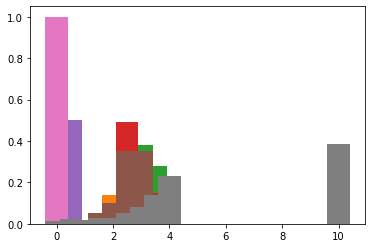

In [27]:
### Robustness checks: focus on big negative mean estimates 
sim_bins_data = SPF_bins
print(str(sum(IndSPF_pk['PRCCPIMean1']<-2))+' abnormals')
ct=0
figure=plt.plot()
for id in IndSPF_pk.index[IndSPF_pk['PRCCPIMean1']<-2]:
    print(id)
    print(IndSPF_pk['PRCCPIMean1'][id])
    sim_probs_data= np.flip(np.array([IndSPF['PRCCPI'+str(n)][id]/100 for n in range(11,21)]))
    plt.bar(sim_bins_data[1:],sim_probs_data)
    print(sim_probs_data)
    stats_est=SynDensityStat(SPF_bins,sim_probs_data)
    print(stats_est['mean'])

IndentationError: expected an indented block (<ipython-input-28-a765e0a89db9>, line 6)